In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Imports

In [ ]:
!pip install openturns --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 MB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.8 MB/s eta 0:00:00


In [ ]:
import os
from datetime import datetime
import openturns as ot
import numpy as np
import math
import torch
import torch.nn as nn
import torch.nn.init as init
from torchvision.datasets import MNIST
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torch.distributions import Normal, MultivariateNormal
from logging import raiseExceptions
from torch.distributions import MultivariateNormal as mv
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy.stats import wasserstein_distance
from torch.utils.tensorboard import SummaryWriter

In [ ]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)

cpu


# Visualization

In [ ]:
def cap_values(data, cap = -1e2):
    """ Cap values in the dataset to a maximum threshold. """
    return np.maximum(data, cap)

In [ ]:
def visualize_joint_distributions_2d_multiple(modalities, generations=None, fontsize=15, labelpad=15,
                                              alpha_data = .1, alpha_gen = .1):
    num_modalities = len(modalities)
    s = 1
    n_rows = 6
    n_cols = 2

    if generations:
        all_gen_modalities = [[modality.detach().cpu().numpy() for modality in generation] for generation in generations]

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(5, 15))

    for k in range(2):
        count = 0
        for i in range(num_modalities):
            for j in range(num_modalities):
                if i >= j:
                    continue

                axs[count, k].scatter(modalities[i][:, k], modalities[j][:, k], s=s, color='orange', alpha=alpha_data)

                if generations:
                    for gen_modalities in all_gen_modalities:
                        axs[count, k].scatter(gen_modalities[i][:, k], gen_modalities[j][:, k], s=s, color='blue', alpha=alpha_gen)

                axs[count, k].set_xlabel(f'$X_{i+1}^{k+1}$', fontsize=fontsize, labelpad=labelpad - 5)
                axs[count, k].set_ylabel(f'$X_{j+1}^{k+1}$', rotation=0, fontsize=fontsize, labelpad=labelpad)

                # axs[count, k].set_xticks([0, 0.5, 1])
                # axs[count, k].set_yticks([0, 0.5, 1])
                axs[count, k].xaxis.set_tick_params(labelsize=fontsize//2)
                axs[count, k].yaxis.set_tick_params(labelsize=fontsize//2)
                axs[count, k].set_xlim([-.25, 1.25])
                axs[count, k].set_ylim([-.25, 1.25])
                # Make tick labels visible on the last row and the first column
                # for label in axs[count, k].get_xticklabels():
                #     label.set_visible(count == n_rows - 1)
                # for label in axs[count, k].get_yticklabels():
                #     label.set_visible(k == 0)

                count += 1

    # plt.subplots_adjust(wspace=-0.1, hspace=-0.1)

    plt.tight_layout()
    plt.show()

In [ ]:
def visualize_joint_distributions_2d(modalities, generation=None):
    num_modalities = len(modalities)
    num_samples = modalities[0].shape[1]
    s=1

    if generation:
        gen_modalities = [modality.detach().cpu().numpy() for modality in generation]

    # Create a figure with subplots in a grid the size of the number of modalities
    fig, axs = plt.subplots(num_modalities, num_modalities, figsize=(10, 10))

    for i in range(num_modalities):
        for j in range(num_modalities):
            # Skip plotting for same modality pair
            if i >= j:
                # axs[i, j].axis('off')
                continue

            # Scatter plot for the x coordinates
            axs[i, j].scatter(modalities[i][:, 0], modalities[j][:, 0], s=s, color='orange', alpha=0.5, label='Real x')
            axs[j, i].scatter(modalities[i][:, 1], modalities[j][:, 1], s=s, color='orange', alpha=0.5, label='Real y')

            if generation:
                # Scatter plot for the generated x coordinates
                axs[i, j].scatter(gen_modalities[i][:, 0], gen_modalities[j][:, 0], s=s, color='blue', alpha=0.2, label='Generated x')
                # Scatter plot for the generated y coordinates
                axs[j, i].scatter(gen_modalities[i][:, 1], gen_modalities[j][:, 1], s=s, color='blue', alpha=0.2, label='Generated y')

            axs[i, j].set_xlabel(f'Modality {i+1} x')
            axs[i, j].set_ylabel(f'Modality {j+1} x')

            axs[j, i].set_xlabel(f'Modality {i+1} y')
            axs[j, i].set_ylabel(f'Modality {j+1} y')

    # Set legends for the first and last plots for clarity
    axs[0, 1].legend(loc='upper right')
    axs[num_modalities-1, num_modalities-2].legend(loc='upper right')

    plt.tight_layout()
    plt.show()

In [ ]:
# import matplotlib.pyplot as plt

# def visualize_joint_distributions_2d(modalities, coordinate = 0, generation=None):
#     num_modalities = len(modalities)
#     num_samples = modalities[0].shape[1]

#     if generation:
#         gen_modalities = [modality.detach().cpu().numpy() for modality in generation]

#     # Create a figure with subplots in a grid the size of the number of modalities
#     fig, axs = plt.subplots(num_modalities, num_modalities, figsize=(10, 10))

#     for i in range(num_modalities):
#         for j in range(num_modalities):
#             if i == j:
#                 axs[i, j].text(0.5, 0.5, f'Modality {i+1}', horizontalalignment='center', verticalalignment='center')
#                 axs[i, j].axis('off')
#             else:
#                 # Scatter plot for the real coordinates
#                 axs[i, j].scatter(modalities[i][:, 0], modalities[j][:, 0], s=5, color='orange', alpha=0.5, label='Real x')
#                 axs[j, i].scatter(modalities[i][:, 0], modalities[j][:, 0], s=5, color='orange', alpha=0.5)

#                 if generation:
#                     # Scatter plot for the generated coordinates
#                     axs[i, j].scatter(gen_modalities[i][:, 0], gen_modalities[j][:, 0], s=5, color='blue', alpha=0.2, label='Generated x')
#                     axs[j, i].scatter(gen_modalities[i][:, 0], gen_modalities[j][:, 0], s=5, color='blue', alpha=0.2)

#             axs[i, j].set_xlabel(f'Modality {i+1} x')
#             axs[i, j].set_ylabel(f'Modality {j+1} x')

#             axs[j, i].set_xlabel(f'Modality {i+1} x')
#             axs[j, i].set_ylabel(f'Modality {j+1} x')

#     # Set legends for the first subplot in the grid for clarity
#     axs[0, 1].legend(loc='upper right')

#     plt.tight_layout()
#     plt.show()


In [ ]:
def plot_cdf_histograms(generation, dataset_cdfs, copulas):
    """
    Plots histograms for the CDFs of the generated modalities and compares them with the dataset CDFs.

    Parameters:
    - generation: A list of generated modality tensors from the model.
    - dataset_cdfs: A dictionary of CDF tensors from the dataset.
    - copulas: A list of copulas used to relate modalities.
    """
    # Extract modalities and concatenate to form pairs
    modalities_pairs = {
        'cdf01': torch.cat((generation[0][:, 0].unsqueeze(1), generation[1][:, 0].unsqueeze(1)), 1),
        'cdf23': torch.cat((generation[2][:, 0].unsqueeze(1), generation[3][:, 0].unsqueeze(1)), 1),
        'cdf12': torch.cat((generation[1][:, 1].unsqueeze(1), generation[2][:, 1].unsqueeze(1)), 1),
        'cdf03': torch.cat((generation[0][:, 1].unsqueeze(1), generation[3][:, 1].unsqueeze(1)), 1)
    }

    # Calculate CDFs for the generated data
    generated_cdfs = {name: np.array(cop.computeCDF(modalities_pairs[name].detach().cpu().numpy()))
                      for name, cop in zip(modalities_pairs, copulas)}

    # Plotting
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    for idx, (name, gen_cdf) in enumerate(generated_cdfs.items()):
        ax = axes[idx]
        # Plot histogram for generated data
        sns.histplot(gen_cdf, ax=ax, color='blue', alpha=0.6, label='Generated CDF')
        # Plot histogram for dataset CDF
        sns.histplot(dataset_cdfs[name].detach().cpu().numpy(), ax=ax, color='red', alpha=0.6, label='Dataset CDF')
        ax.set_title(f'Histogram for {name}')
        ax.legend()

    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming you have a variable 'generation' containing the generated modalities
# And 'dataset_instance.cdfs' containing the CDFs from the dataset
# And 'copulas' being the list of copula objects
# plot_cdf_histograms(generation, dataset_instance.cdfs, copulas)


In [ ]:
def plot_pdf_histograms(pdf1,pdf2,gen_pdf1,gen_pdf2):
    """
    Plots histograms for the CDFs of the generated modalities and compares them with the dataset CDFs.

    Parameters:
    - generation: A list of generated modality tensors from the model.
    - dataset_cdfs: A dictionary of CDF tensors from the dataset.
    - copulas: A list of copulas used to relate modalities.
    """




    # Plotting
    fig, axes = plt.subplots(1, 2, figsize=(20, 5))
    # Plot histogram for generated data
    sns.histplot(gen_pdf1, ax=axes[0], color='blue', alpha=0.6, label='Generated PDF')
    # Plot histogram for dataset CDF
    sns.histplot(pdf1, ax=axes[0], color='red', alpha=0.6, label='Dataset PDF')
    axes[0].set_title('Histogram for copula 1')
    axes[0].legend()
    # Plot histogram for generated data
    sns.histplot(gen_pdf2, ax=axes[1], color='blue', alpha=0.6, label='Generated PDF')
    # Plot histogram for dataset CDF
    sns.histplot(pdf2, ax=axes[1], color='red', alpha=0.6, label='Dataset PDF')
    axes[1].set_title('Histogram for copula 2')
    axes[1].legend()

    plt.tight_layout()
    plt.show()

In [ ]:
def visualize_marginals_multiple(modalities, generations=None, fontsize=15, labelpad=15,
                                              alpha_data = .7, alpha_gen = .2, bins=100):
    num_modalities = len(modalities)
    s = 1
    n_rows = num_modalities
    n_cols = 2

    if generations:
        all_gen_modalities = [[modality.detach().cpu().numpy() for modality in generation] for generation in generations]

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(5, 11))

    for k in range(2):
        for i in range(num_modalities):
            axs[i, k].hist(modalities[i][:, k], color='orange',bins=bins, alpha=alpha_data, density =True)

            if generations:
                for gen_modalities in all_gen_modalities:
                    axs[i, k].hist(gen_modalities[i][:, k], bins=bins, color='blue', alpha=alpha_gen, density =True)

            axs[i, k].set_xlabel(f'$X_{i+1}^{k+1}$', fontsize=fontsize, labelpad=labelpad - 5)
            axs[i, k].set_xlim([-.25, 1.25])
            # axs[i, k].xaxis.set_tick_params(labelsize=fontsize//2)

    plt.subplots_adjust(wspace=0, hspace=0)

    plt.tight_layout()
    plt.show()

# Dataset

In [ ]:
formulas = ['x^3/2-x/2+1',  'x^2-x+1']
# ali_copula = ot.AliMikhailHaqCopula(0.5)

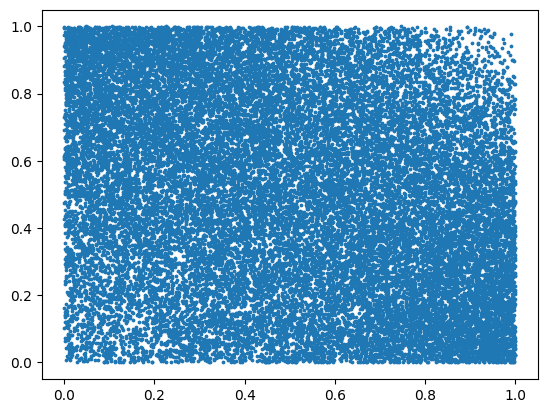

In [ ]:
ali_copula = ot.AliMikhailHaqCopula(-.99)
X = ali_copula.getSample(30000)
plt.scatter(X[:,0], X[:,1], s=3)

In [ ]:
def get_copulas(formulas = formulas):
    symbolic_functions = [ot.SymbolicFunction('x', f) for f in formulas]
    copulas = [ot.ExtremeValueCopula(s) for s in symbolic_functions]
    return copulas

In [ ]:
class Indep_Unif_Copula:
    def __init__(self):
        self.sample = None
    def getSample(self, n):
        self.sample = torch.rand((n, 2))
        return self.sample
    def computeCDF(self, sample):
        return sample[:,0]*sample[:,1]

In [ ]:
unif_copula = Indep_Unif_Copula()

In [ ]:
indep_copula = ot.IndependentCopula()
x_copulas = get_copulas()
y_copulas = [ali_copula, indep_copula]
copulas = x_copulas + y_copulas

In [ ]:
# class Copula_Dataset(Dataset):
#     def __init__(self, copulas, num_samples=1000, dim=2, for_predictor = False):

#         self.copulas = copulas
#         self.num_samples = num_samples
#         self.for_predictor = for_predictor

#         if for_predictor:
#             u1, u2, self.cdf_12 = self.generate_pair_from_copula(copulas[0], num_samples, dim)
#             self.data = [u1, u2, self.cdf_12]
#         else:
#             self.data, self.cdfs = [], []
#             for c in copulas:
#                 u0, u1, cdf = self.generate_pair_from_copula(c, num_samples, dim)
#                 self.data+=[u0,u1]
#                 self.cdfs.append(cdf)


#     def generate_pair_from_copula(self, copula, n, dim):
#         dataset = []
#         x,y,cdf = [], [], []

#         for _ in range(dim):
#             sample = copula.getSample(n)#np.array()
#             # print(sample)
#             xi,yi = sample[:,0], sample[:,1]
#             tx = torch.tensor(xi)
#             ty = torch.tensor(yi)
#             tcdf = torch.tensor(copula.computeCDF(sample))

#             if self.for_predictor:
#                 return tx, ty, tcdf

#             x.append(tx)
#             y.append(ty)
#             cdf.append(tcdf)

#         x = torch.transpose(torch.stack(x),0,1).squeeze(2)
#         y = torch.transpose(torch.stack(y),0,1).squeeze(2)
#         cdf = torch.transpose(torch.stack(cdf),0,1).squeeze(2)
#         return x, y, cdf

#     def __len__(self):
#         return self.num_samples

#     def __getitem__(self, idx):
#         return [d[idx,:].float() for d in self.data]


In [ ]:
def compute_generation_cdf(generation, copulas, dataset = None):
    c01, c1 = get_copulas()

    u_12 = torch.cat((u1,u2),1).numpy()
    u_34 = torch.cat((u3,u4),1).numpy()
    cdf0, cdf1 = np.array(c0.computeCDF(u_12)).flatten(), np.array(c1.computeCDF(u_34)).flatten()

    if dataset != None:
        data_cdf0, data_cdf1 = [np.array(cdf.flatten(0)) for cdf in dataset.cdfs]
        return cdf0, cdf1, data_cdf0, data_cdf1

    return cdf0, cdf1

In [ ]:
class Three_Copula_Dataset(Dataset):
    def __init__(self, copulas, num_samples=1000):

        self.copulas = copulas
        self.num_samples = num_samples


        self.data, self.cdfs = [], []
        x00,x10, self.cdf01 = self.generate_pair_from_copula(copulas[0], num_samples)
        x20,x30, self.cdf23 = self.generate_pair_from_copula(copulas[1], num_samples)
        x01,x31, self.cdf03 = self.generate_pair_from_copula(copulas[2], num_samples)
        x11,x21, self.cdf12 = self.generate_pair_from_copula(copulas[3], num_samples)


        self.x0 = torch.cat((x00,x01), 1)
        self.x1 = torch.cat((x10,x11), 1)
        self.x2 = torch.cat((x20,x21), 1)
        self.x3 = torch.cat((x30,x31), 1)

        self.data = [self.x0, self.x1, self.x2, self.x3]

        self.cdfs = dict()
        self.cdfs['cdf01'] = self.cdf01
        self.cdfs['cdf23'] = self.cdf23
        self.cdfs['cdf03'] = self.cdf03
        self.cdfs['cdf12'] = self.cdf12


    def generate_pair_from_copula(self, copula, n):

        sample = copula.getSample(n)#np.array()
        # print(sample)
        xi,yi = sample[:,0], sample[:,1]
        x = torch.tensor(xi).reshape(-1,1)
        y = torch.tensor(yi).reshape(-1,1)
        cdf = torch.tensor(copula.computeCDF(sample)).reshape(-1,1)
        return x, y, cdf

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return [d[idx,:].float() for d in self.data]


In [ ]:
class StudentCopulaDataset(Dataset):
    def __init__(self, student_params1, student_params2, num_samples=10000):
        self.num_samples = num_samples

        # Create the two Student copulas
        self.copula1 = self.create_student_copula(**student_params1)
        self.copula2 = self.create_student_copula(**student_params2)

        # Generate samples for each modality
        sample1 = self.copula1.getSample(num_samples)
        self.cdf1 = torch.tensor(self.copula1.computeCDF(sample1)).reshape(-1,1)
        sample2 = self.copula2.getSample(num_samples)
        self.cdf2 = torch.tensor(self.copula2.computeCDF(sample2)).reshape(-1,1)

        # Split the 4-tuples into 2-tuples and create tensors
        x0, x1 = sample1[:, 0], sample1[:, 1]
        x2, x3 = sample1[:, 2], sample1[:, 3]
        x4, x5 = sample2[:, 0], sample2[:, 1]
        x6, x7 = sample2[:, 2], sample2[:, 3]

        # Create the final 2D modalities by concatenating the corresponding samples
        self.x0 = torch.cat((torch.tensor(x0).reshape(-1,1), torch.tensor(x4).reshape(-1,1)), 1)
        self.x1 = torch.cat((torch.tensor(x1).reshape(-1,1), torch.tensor(x5).reshape(-1,1)), 1)
        self.x2 = torch.cat((torch.tensor(x2).reshape(-1,1), torch.tensor(x6).reshape(-1,1)), 1)
        self.x3 = torch.cat((torch.tensor(x3).reshape(-1,1), torch.tensor(x7).reshape(-1,1)), 1)

        # Store the data as a list of tensors
        self.data = [self.x0, self.x1, self.x2, self.x3]

        # Store cdfs in a dico
        self.cdfs = dict()
        self.cdfs['cdf1'] = self.cdf1
        self.cdfs['cdf2'] = self.cdf2

    def create_student_copula(self, dimension, nu, mu, sigma, correlation_matrix):
        # Define the multivariate Student distribution
        student = ot.Student(nu, mu, sigma, correlation_matrix)
        # Create the copula using Sklar's theorem
        copula = ot.SklarCopula(student)
        return copula

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return [d[idx, :].float() for d in self.data]


In [ ]:
class NormalCopulaDataset(Dataset):
    def __init__(self, student_params1, student_params2, num_samples=10000):
        self.num_samples = num_samples

        # Create the two Student copulas
        self.copula1 = self.create_normal_copula(**student_params1)
        self.copula2 = self.create_normal_copula(**student_params2)

        # Generate samples for each modality
        sample1 = self.copula1.getSample(num_samples)
        # self.cdf1 = torch.tensor(self.copula1.computeCDF(sample1)).reshape(-1,1)
        self.log_pdf1 = torch.tensor(self.copula1.computeLogPDF(sample1)).reshape(-1,1)
        sample2 = self.copula2.getSample(num_samples)
        # self.cdf2 = torch.tensor(self.copula2.computeCDF(sample2)).reshape(-1,1)
        self.log_pdf2 = torch.tensor(self.copula2.computeLogPDF(sample2)).reshape(-1,1)

        # Split the 4-tuples into 2-tuples and create tensors
        x0, x1 = sample1[:, 0], sample1[:, 1]
        x2, x3 = sample1[:, 2], sample1[:, 3]
        x4, x5 = sample2[:, 0], sample2[:, 1]
        x6, x7 = sample2[:, 2], sample2[:, 3]

        # Create the final 2D modalities by concatenating the corresponding samples
        self.x0 = torch.cat((torch.tensor(x0).reshape(-1,1), torch.tensor(x4).reshape(-1,1)), 1)
        self.x1 = torch.cat((torch.tensor(x1).reshape(-1,1), torch.tensor(x5).reshape(-1,1)), 1)
        self.x2 = torch.cat((torch.tensor(x2).reshape(-1,1), torch.tensor(x6).reshape(-1,1)), 1)
        self.x3 = torch.cat((torch.tensor(x3).reshape(-1,1), torch.tensor(x7).reshape(-1,1)), 1)

        # Store the data as a list of tensors
        self.data = [self.x0, self.x1, self.x2, self.x3]

        # Store cdfs in a dico
        # self.cdfs = dict()
        # self.cdfs['cdf1'] = self.cdf1
        # self.cdfs['cdf2'] = self.cdf2

        # Store log_pdfs in a dico
        self.log_pdfs = dict()
        self.log_pdfs['log_pdf1'] = self.log_pdf1
        self.log_pdfs['log_pdf2'] = self.log_pdf2

    def create_normal_copula(self,  mu, sigma, correlation_matrix):
        # Define the multivariate Student distribution
        normal = ot.Normal(mu, sigma, correlation_matrix)
        # Create the copula using Sklar's theorem
        copula = ot.SklarCopula(normal)
        return copula

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return [d[idx, :].float() for d in self.data]


In [ ]:
R1 = ot.CorrelationMatrix(4)
for i in range(4):
    for j in range(4):
        if i!=j:
            R1[i,j]=(-1)**(i+j)*.9
params1 = {
    'mu': [3.0] * 4,
    'sigma': [1.] * 4,
    'correlation_matrix': R1
}
R2 = ot.CorrelationMatrix(4)
for i in range(4):
    for j in range(4):
        if i!=j:
            R2[i,j]=(1)**(i+j)*.9
params2 = {
    'mu': [3.0] * 4,
    'sigma': [1.] * 4,
    'correlation_matrix': R2
}
dataset = NormalCopulaDataset(params1,params2)

In [ ]:
log_pdf1 = torch.squeeze(dataset.log_pdfs['log_pdf1']).numpy()
log_pdf2 = torch.squeeze(dataset.log_pdfs['log_pdf2']).numpy()

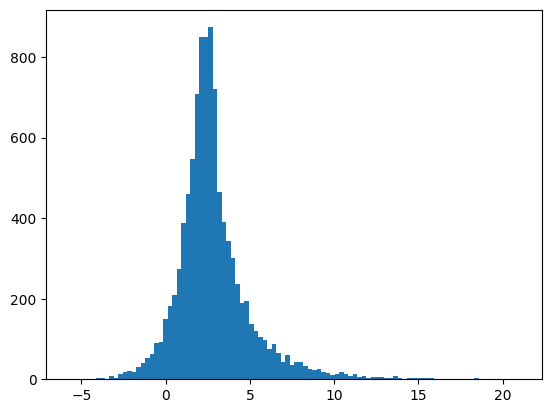

In [ ]:
plt.hist(log_pdf1[log_pdf1>-1e1], bins = 100)
plt.show()

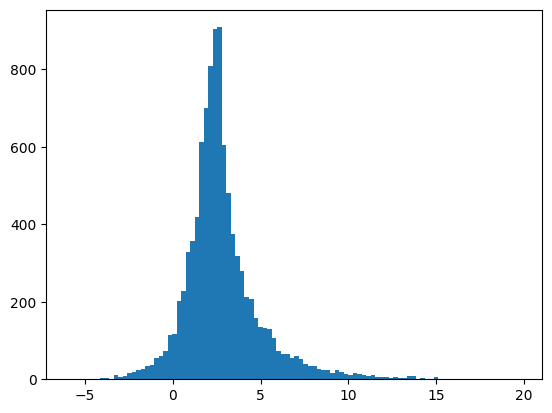

In [ ]:
plt.hist(log_pdf2[log_pdf2>-1e1], bins = 100)
plt.show()

In [ ]:
# # Ensure the directory exists
# sample_size_folder = "/content/drive/MyDrive/Phd/copulas/normal"
# os.makedirs(sample_size_folder, exist_ok=True)

# # Save the CDFs to file
# torch.save(dataset.cdfs, f'{sample_size_folder}/cdfs.pth')

# # Save the data tensors to files
# for i, data_tensor in enumerate(dataset.data):
#     torch.save(data_tensor, f'{sample_size_folder}/data_{i}.pth')


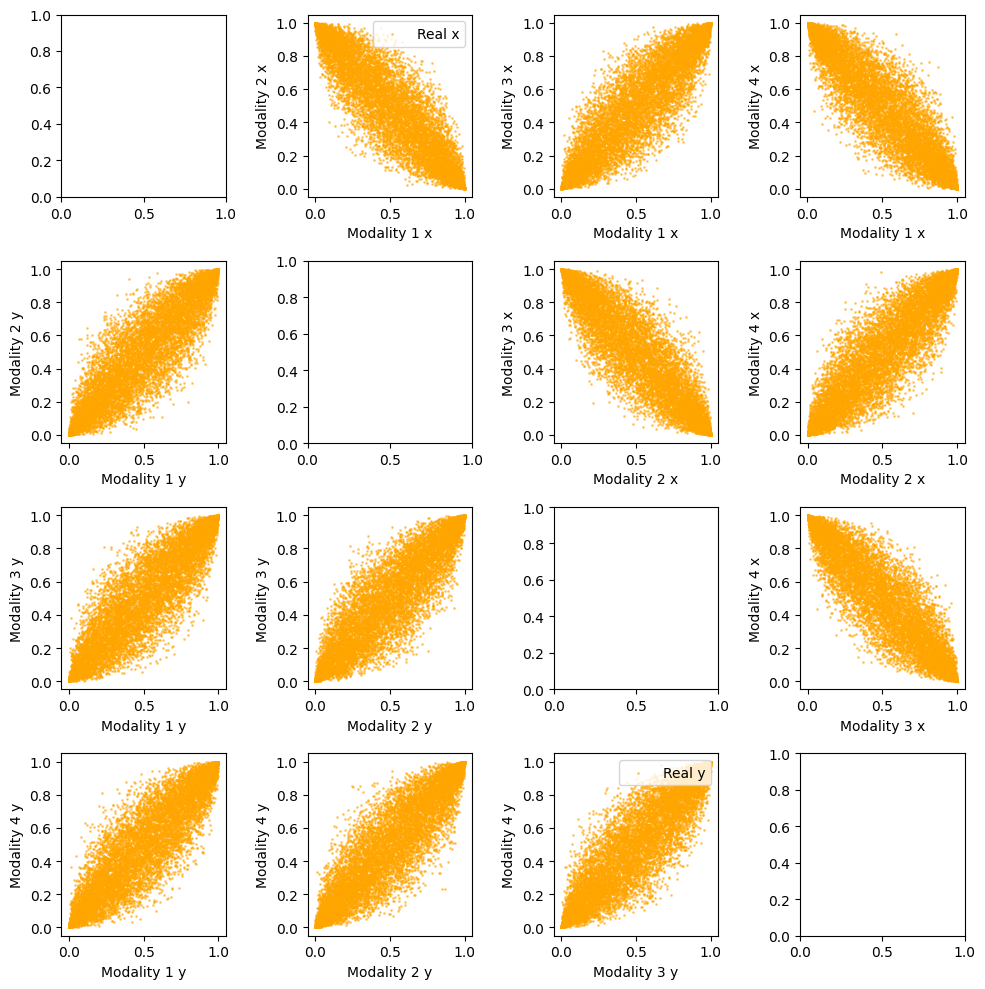

In [ ]:
visualize_joint_distributions_2d(dataset.data)

In [ ]:
# Parameters for the first Student copula
R = ot.CorrelationMatrix(4)
# R[3,1] = .9
# R[1,3] = .9
# R[2,0] = -.9
# R[0,2] = -.9
# R[0,3] = .2
# R[3,0] = .2
for i in range(4):
    for j in range(4):
        if i!=j:
            R[i,j]=(-1)**(i+j)*.7
student_params1 = {
    'dimension': 4,
    'nu': 10.0,
    'mu': [3.0] * 4,
    'sigma': [1.] * 4,
    'correlation_matrix': R
}
student_params2 = {
    'dimension': 4,
    'nu': 10.0,
    'mu': [3.0] * 4,
    'sigma': [1.] * 4,
    'correlation_matrix': R
}
# student_params1 = {
#     'dimension': 4,
#     'nu': 1.0,
#     'mu': [0.0] * 4,
#     'sigma': [0.1] * 4,
#     'correlation_matrix': ot.CorrelationMatrix(4)
# }
# # Parameters for the second Student copula (with different parameters)
# student_params2 = {
#     'dimension': 4,
#     'nu': 1.0,
#     'mu': [0.0] * 4,
#     'sigma': [0.1] * 4,
#     'correlation_matrix': ot.CorrelationMatrix(4)
# }

# Create the dataset instance
# dataset = StudentCopulaDataset(student_params1, student_params2,10)


In [ ]:
dim = 2
R = ot.CorrelationMatrix(dim)
params = {
    'dimension': dim,
    'nu': 10.0,
    'mu': [3.0] * dim,
    'sigma': [1.] * dim,
    'correlation_matrix': R
}
student = ot.Student(10.,  [3.0] * dim, [1.] * dim, R)
copula = ot.SklarCopula(student)
sample = copula.getSample(10)
cdf = copula.computeCDF(sample)

In [ ]:
cdf_path = "/content/drive/MyDrive/Phd"

In [ ]:
sample.asDataFrame()

,X0,X1
0,0.496660,0.852244
1,0.889969,0.556316
2,0.788306,0.479570
3,0.851106,0.702309
4,0.702291,0.837849
5,0.418902,0.510366
6,0.311928,0.773872
7,0.075121,0.729216
8,0.446148,0.436208
9,0.990647,0.737793


In [ ]:
cdf.asDataFrame()

,v0
0,0.423235
1,0.495740
2,0.377810
3,0.599951
4,0.590634
5,0.213751
6,0.239420
7,0.052762
8,0.194786
9,0.731458


In [ ]:
sample

,X0,X1
0,0.4966599,0.8522437
1,0.8899695,0.5563165
2,0.7883059,0.4795704
3,0.8511058,0.7023085
4,0.702291,0.8378487
5,0.418902,0.5103664
6,0.3119276,0.7738719
7,0.07512135,0.729216
8,0.4461484,0.4362078
9,0.9906474,0.7377929


In [ ]:
R = ot.CorrelationMatrix(3)
R[0, 1] = 0.25
R[1, 2] = 0.25
copula = ot.SklarCopula(ot.Normal([1.0, 2.0, 3.0], [2.0, 3.0, 1.0], R))
sample = copula.getSample(5)
copula.computeCDF(sample)

,v0
0,0.03060014
1,0.03041406
2,0.2102723
3,0.1152906
4,0.4957112


In [ ]:
print(R)

[[ 1    0.25 0    ]
 [ 0.25 1    0.25 ]
 [ 0    0.25 1    ]]


In [ ]:
# dataset = Copula_Dataset(get_copulas(), num_samples=3000, for_predictor = False)
# dataset = Three_Copula_Dataset(copulas, num_samples=10000)

In [ ]:
def get_dataloader(param_dico, copulas):
    # dataset = Three_Copula_Dataset(copulas, num_samples=param_dico['num_samples'])
    # dataset = StudentCopulaDataset(student_params1, student_params2, param_dico['num_samples'])
    dataset = NormalCopulaDataset(params1,params2, num_samples=param_dico['num_samples'])
    param_dico.pop('num_samples', None)
    return DataLoader(dataset, **param_dico)


In [ ]:
train_loader = get_dataloader({'num_samples':10000, 'batch_size':1024, 'shuffle':True, 'num_workers':2}, copulas)

# Utils

In [ ]:
def plot_marginals(data, coordinate, generation):
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))  # Adjust the figure size as needed

    # Plot histograms
    for i in range(4):
        axes[i].hist(data[i][:, coordinate], bins=30, alpha=0.5, color='orange')
        axes[i].hist(generation[:, i], bins=30, alpha=0.5, color='blue')  # You can customize the number of bins and color
        axes[i].set_title(f'Modality {i+1}')
        axes[i].set_xlabel('Value')
        axes[i].set_ylabel('Frequency')

    # Improve layout to prevent overlap
    plt.tight_layout()
    title = f'copula_{coordinate}'
    plt.title(title)

    # Show the plot
    plt.show()

In [ ]:
def get_emp_dist(data1, plot=False):
    # Create histograms
    bins = np.linspace(-7, 20, 100)  # Adjust the bin edges as needed
    hist1, bin_edges1  = np.histogram(data1, bins=bins, density=True)

    # Plotting histograms for visualization
    if plot:
        plt.hist(data1, bins=bins, alpha=0.5, label='Data 1', density=True)
        plt.legend()
        plt.show()

    # Normalize histograms by dividing by the sum of their bin heights multiplied by bin widths
    bin_widths1 = np.diff(bin_edges1)
    hist1_normalized = hist1 * bin_widths1 / (hist1 * bin_widths1).sum()
    return hist1_normalized
def get_jensen(data1,data2,eps=None):
    if eps ==None:
        eps = np.finfo(float).eps
    p = get_emp_dist(data1)
    q = get_emp_dist(data2)
    return scipy.spatial.distance.jensenshannon(p+eps, q+eps)

In [ ]:
def plot_distributions(data, px_u):
    fig, axs = plt.subplots(4, 4, figsize=(20, 20))
    for i in range(4):
        for j in range(4):
            # Extract the mean of the distribution
            mean = px_u[i][j].squeeze(0).cpu().detach().numpy()
            data_i = data[i].detach().cpu().numpy()
            # Plot the distribution on the respective subplot

            axs[i, j].scatter(data_i[:,0], data_i[:,1],  color='orange', alpha=0.5, label='Real')
            axs[i, j].scatter(mean[:, 0], mean[:, 1],  color='blue', alpha=0.2, label='Generated')
            axs[i, j].set_title(f'Distribution {i+1}, {j+1}')
            axs[i, j].legend()
            axs[i, j].axis('equal')  # Ensures equal scaling on both axes
    plt.suptitle('Conditional generation, generate modality i from modality j', fontsize=20)
    # Adjust layout
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust the rectangle [left, bottom, right, top] in normalized (0, 1) figure coordinates
    plt.subplots_adjust(top=0.95)  # Adjust the top of the subplots to make more space for the title
    plt.show()

In [ ]:
def plot_training_curves(mean_losses, mean_log_px_zs, mean_kls):
    epochs = len(mean_losses)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 3, 1)
    plt.plot(range(epochs), mean_losses, label='Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss')

    plt.subplot(1, 3, 2)
    plt.plot(range(epochs), mean_log_px_zs, label='log p(x|z)')
    plt.xlabel('Epochs')
    plt.ylabel('log p(x|z)')
    plt.title('log p(x|z)')

    plt.subplot(1, 3, 3)
    plt.plot(range(epochs), mean_kls, label='KL Divergence')
    plt.xlabel('Epochs')
    plt.ylabel('KL Divergence')
    plt.title('KL Divergence')

    plt.tight_layout()
    plt.show()

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
def compute_generation_cdf(generation, dataset = None):
    c0, c1 = get_copulas()

    u1,u2,u3,u4 = [g.flatten(0).unsqueeze(1).detach().cpu() for g in generation]

    u_12 = torch.cat((u1,u2),1).numpy()
    u_34 = torch.cat((u3,u4),1).numpy()
    cdf0, cdf1 = np.array(c0.computeCDF(u_12)).flatten(), np.array(c1.computeCDF(u_34)).flatten()

    if dataset != None:
        data_cdf0, data_cdf1 = [np.array(cdf.flatten(0)) for cdf in dataset.cdfs]
        return cdf0, cdf1, data_cdf0, data_cdf1

    return cdf0, cdf1

In [ ]:
def plot_histograms(cdf0, data_cdf0, cdf1, data_cdf1):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns of subplots

    # Plotting histograms for the first pair of arrays
    axs[0].hist(cdf0, bins=20, alpha=0.5, label='cdf0')
    axs[0].hist(data_cdf0, bins=20, alpha=0.5, label='data_cdf0')
    axs[0].set_title('cdf0 vs. data_cdf0')
    axs[0].legend()

    # Plotting histograms for the second pair of arrays
    axs[1].hist(cdf1, bins=20, alpha=0.5, label='cdf1')
    axs[1].hist(data_cdf1, bins=20, alpha=0.5, label='data_cdf1')
    axs[1].set_title('cdf1 vs. data_cdf1')
    axs[1].legend()

    plt.tight_layout()
    plt.show()


In [ ]:
def plot_modalities(dataset, generation, titles=['X1 vs. X2', 'X3 vs. X4', 'X1 vs. X3', 'X2 vs. X4']):

    train_data = [d.flatten(0).numpy() for d in dataset.data]
    generated_data =  [g.flatten(0).cpu().detach().numpy() for g in generation]

    fig, axs = plt.subplots(2, 2, figsize=(12, 12))
    axs = axs.ravel()  # Flatten the array to make iteration easier

    # Extracting generated data for plotting
    u1, u2, u3, u4 = generated_data

    # Extracting training data for plotting
    train_u1, train_u2, train_u3, train_u4 = train_data

    # Pairwise combinations for plotting
    combinations = [(u1, u2, train_u1, train_u2),
                    (u3, u4, train_u3, train_u4),
                    (u1, u3, train_u1, train_u3),
                    (u2, u4, train_u2, train_u4)]

    for ax, (gen_x, gen_y, train_x, train_y), title in zip(axs, combinations, titles):
        ax.scatter(train_x, train_y, alpha=0.5, color='orange', label='Training Data', s=10)
        ax.scatter(gen_x, gen_y, alpha=0.5, color='blue', label='Generated Data', s=10)
        ax.set_title(title, fontsize=14)
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    plt.show()


In [ ]:
# def plot_modalities(dataset, generation, titles=['u1 vs. u2', 'u3 vs. u4', 'u1 vs. u3', 'u2 vs. u4']):

#     train_data = [d.flatten(0).numpy() for d in dataset.data]
#     generated_data =  [g.flatten(0).cpu().detach().numpy() for g in generation]

#     fig, axs = plt.subplots(2, 2, figsize=(12, 12))
#     axs = axs.ravel()  # Flatten the array to make iteration easier

#     # Extracting generated data for plotting
#     u1, u2, u3, u4 = generated_data

#     # Extracting training data for plotting
#     train_u1, train_u2, train_u3, train_u4 = train_data

#     # Pairwise combinations for plotting
#     combinations = [(u1, u2, train_u1, train_u2),
#                     (u3, u4, train_u3, train_u4),
#                     (u1, u3, train_u1, train_u3),
#                     (u2, u4, train_u2, train_u4)]

#     for ax, (gen_x, gen_y, train_x, train_y), title in zip(axs, combinations, titles):
#         ax.scatter(train_x, train_y, alpha=0.5, label='Training Data', s=10)
#         ax.scatter(gen_x, gen_y, alpha=0.5, label='Generated Data', s=10)
#         ax.set_title(title)
#         ax.legend()
#         ax.grid(True)

#     plt.tight_layout()
#     plt.show()



In [ ]:
def correlation_from_covariance(covariance):
    v = np.sqrt(np.diag(covariance))
    outer_v = np.outer(v, v)
    correlation = covariance / outer_v
    correlation[covariance == 0] = 0
    return correlation


In [ ]:
def plot_cov_corr_matrices(gmrf_vae):
    L = gmrf_vae.get_cholesky().detach().cpu().numpy()
    Sigma_p = np.matmul(L, L.T)

    corr_p = correlation_from_covariance(Sigma_p)

    L_z_x = gmrf_vae.qz_x.scale_tril
    L = torch.mean(L_z_x,0).detach().cpu().numpy()
    Sigma_q = np.matmul(L, L.T)

    corr_q = correlation_from_covariance(Sigma_q)

    fig, axs = plt.subplots(2, 2, figsize=(12, 12))

    images = []
    titles = [r'$\Sigma_{p}$ covariance matrix', 'Correlation matrix $\mathcal{p}(z)$',
              '$\Sigma_{\mathcal{q}}$ covariance matrix', 'Correlation matrix $\mathcal{q}(z|X)$']
    matrices = [Sigma_p, corr_p, Sigma_q, corr_q]

    for ax, matrix, title in zip(axs.flat, matrices, titles):
        im = ax.imshow(matrix, cmap=plt.get_cmap('bwr'))
        ax.set_title(title)
        ax.axis('off')
        fig.colorbar(im, ax=ax, orientation='vertical')

    plt.tight_layout()
    plt.show()

In [ ]:
def plot_potentials(potentials, sigma = False):
    # Ensure the input is converted to a numpy array to handle operations correctly
    potentials = np.array(potentials)

    # Calculate the absolute values of the potentials and normalize
    abs_potentials = np.abs(potentials)
    abs_potentials = abs_potentials / np.max(abs_potentials)

    # Create a figure and axis object with 1 row and 2 columns
    fig, ax = plt.subplots(figsize = (10,5), nrows=1, ncols=2)

    # Plot the heatmap for the mean of the potentials
    # Assuming 'potentials' is a 3D array where you want to take the mean across the first dimension
    # Corrected the heatmap1 to use the mean of the potentials if that's the original intention
    heatmap1 = ax[0].imshow(potentials, cmap='plasma')  # Changed colormap to 'plasma'
    if sigma:
        title = 'Mean of $\Sigma$ for $\mathcal{q}(z|X)$'
    else:
        title = 'Mean of Potentials ($ψ_{ij}$) for $\mathcal{p}(z)$'
    ax[0].set_title(title)

    # Plot the heatmap for the absolute values of normalized potentials
    heatmap2 = ax[1].imshow(abs_potentials, cmap='coolwarm')  # Changed colormap to 'coolwarm'
    if sigma:
        title = '|$\Sigma$| / max(|$\Sigma$|) for $\mathcal{q}(z|X)$'
    else:
        title = '|$ψ_{ij}$| / max(|$ψ_{ij}$|) for $\mathcal{p}(z)$'
    ax[1].set_title(title)

    # Add colorbars with adjusted size and padding
    cbar1 = fig.colorbar(heatmap1, ax=ax[0], fraction=0.046, pad=0.04)
    cbar1.set_label('Intensity')
    cbar2 = fig.colorbar(heatmap2, ax=ax[1], fraction=0.046, pad=0.04)
    cbar2.set_label('Intensity')

    # Show plot
    plt.show()

In [ ]:
def compute_n_off_diag(modalities_dim): # Copute the number of lower of diagonal elements
    n = len(modalities_dim)
    partial_sums = [modalities_dim[-1]]
    for i in range(n-2):
        partial_sums.append(partial_sums[-1]+modalities_dim[-i-2])
    partial_sums = partial_sums[::-1]
    res = 0
    for i in range(n-1):
        res+=partial_sums[i]*modalities_dim[i]
    return res

In [ ]:
def assemble_covariance_matrix(mu_list, chol_list, off_diag_coeffs, modalities_dim):
    # Total dimension of the assembled matrix.
    full_dim = sum(modalities_dim)

    # Initialize a matrix with zeros, of shape (batch_size, full_dim, full_dim).
    full_matrix = torch.zeros((mu_list[0].shape[0], full_dim, full_dim))

    # ------------------------------
    # 1. Fill in the diagonal blocks
    # ------------------------------

    start_idx = 0
    for i, dim in enumerate(modalities_dim):
        # For each modality, place its Cholesky diagonal block in the main matrix.
        full_matrix[:, start_idx:start_idx+dim, start_idx:start_idx+dim] = chol_list[i]

        # Move the starting index by the dimension of the current modality to position for the next modality.
        start_idx += dim

    # ----------------------------------------------
    # 2. Calculate the offsets for each modality block
    # This will be helpful in placing off-diagonal blocks
    # ----------------------------------------------

    offsets = [0]  # Starting from the beginning of the matrix.
    for dim in modalities_dim[:-1]:
        offsets.append(offsets[-1] + dim)

    # ----------------------------------------------
    # 3. Extract and place off-diagonal blocks
    # ----------------------------------------------

    start_idx = 0  # Reset starting index for off-diagonal coeffs extraction.
    for i, offset in enumerate(offsets[:-1]):
        # Compute how many elements are needed to fill the lines below the ith block.
        # For visualization, consider the matrix representation with blocks shown as 'x' and unfilled spaces as '-'
        # e.g., for 3 modalities:
        # [x x - - - - - - -]
        # [x x - - - - - - -]
        # [- - x x x - - - -]
        # [- - x x x - - - -]
        # [- - x x x - - - -]
        # [- - - - - x x x x]
        # [- - - - - x x x x]
        # [- - - - - x x x x]
        # [- - - - - x x x x]
        #
        # When on the first block (2x2), we need elements for the next two blocks below it (2x3 and 2x4 respectively).
        end_idx = start_idx + modalities_dim[i] * (full_dim - offset - modalities_dim[i])

        # Extract the block of coefficients for the current modality.
        block = off_diag_coeffs[:, start_idx:end_idx].reshape(mu_list[0].shape[0], modalities_dim[i], -1)

        # Place the transpose of the block in the main matrix to fill the lower triangular elements.
        full_matrix[:, offset+modalities_dim[i]:, offset:offset+modalities_dim[i]] = block.transpose(-2, -1)

        # Move the starting index to end index for the next iteration.
        start_idx = end_idx

    return full_matrix


In [ ]:
def initialize_weights(m, method='xavier'):
    """
    Initialize model weights.

    Arguments:
    - m: torch module (typically a layer)
    - method: str, type of initialization ('xavier', 'kaiming', 'orthogonal', 'zero', 'uniform')
    """
    if isinstance(m, nn.Linear):

        # Xavier (Glorot) Initialization
        if method == 'xavier':
            init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)

        # Kaiming (He) Initialization
        elif method == 'kaiming':
            init.kaiming_uniform_(m.weight, nonlinearity='relu')
            m.bias.data.fill_(0.01)

        # Orthogonal Initialization
        elif method == 'orthogonal':
            init.orthogonal_(m.weight)
            m.bias.data.fill_(0.01)

        # Zero Initialization
        elif method == 'zero':
            m.weight.data.fill_(0)
            m.bias.data.fill_(0)

        # Uniform Random Initialization
        elif method == 'uniform':
            m.weight.data.uniform_(-1, 1)
            m.bias.data.fill_(0.01)

        else:
            raise ValueError(f"Unknown initialization method {method}")

In [ ]:
def plot_training_curves(mean_losses, mean_log_px_zs, mean_kls):
    epochs = len(mean_losses)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 3, 1)
    plt.plot(range(epochs), mean_losses, label='Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss')

    plt.subplot(1, 3, 2)
    plt.plot(range(epochs), mean_log_px_zs, label='log p(x|z)')
    plt.xlabel('Epochs')
    plt.ylabel('log p(x|z)')
    plt.title('log p(x|z)')

    plt.subplot(1, 3, 3)
    plt.plot(range(epochs), mean_kls, label='KL Divergence')
    plt.xlabel('Epochs')
    plt.ylabel('KL Divergence')
    plt.title('KL Divergence')

    plt.tight_layout()
    plt.show()

In [ ]:
def plot_generated_images(generated, n):
    """
    Plots the first n x n generated images.

    Parameters:
    - generated: The generated images with shape [batch, 784]
    - n: The grid size for plotting (n x n)
    """
    n_rows = len(generated)
    n_cols = n
    _ , axs = plt.subplots(nrows=n_rows, ncols=n_cols)
    for i in range(n_rows):
        for j in range(n_cols):
            img = generated[i][j,:].view(28,28).detach().cpu().numpy()
            axs[i][j].imshow(img,  cmap='gray')
            axs[i][j].axis(False)
    plt.show()

In [ ]:
def plot_cond_generated(cond, generated, n):
    """
    Plots the first n x n generated images.

    Parameters:
    - generated: The generated images with shape [batch, 784]
    - n: The grid size for plotting (n x n)
    """
    n_rows = len(generated)+1
    n_cols = n
    _ , axs = plt.subplots(nrows=n_rows, ncols=n_cols)
    for i in range(n_rows):
        for j in range(n_cols):
            if i==0:
                img = cond[j,:].view(28,28).detach().cpu().numpy()
            else:
                img = generated[i-1][j,:].view(28,28).detach().cpu().numpy()
            axs[i][j].imshow(img,  cmap='gray')
            axs[i][j].axis(False)
    plt.show()

In [ ]:
def plot_losses(train_losses, test_losses, n_test):
    epochs = range(1, len(train_losses) + 1)
    test_epochs = range(n_test, n_test * len(test_losses) + 1, n_test)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(test_epochs, test_losses, label='Test Loss', linestyle='--', marker='o')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Test Losses')
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
def compute_wasserstein_distances(data, generation):
    """
    Compute the Wasserstein distance between corresponding modalities in two datasets.

    Parameters:
    - data1: The first dataset as a list of 2D tensors [n_batch, 2].
    - data2: The second dataset as a list of 2D tensors [n_batch, 2].

    Returns:
    - A matrix of Wasserstein distances between each pair of modalities for both coordinates.
    """
    num_modalities = len(data)
    distances = np.zeros((num_modalities, 2))  # For each pair of modalities, for each coordinate

    for i in range(num_modalities):
        distances[i, 0] = wasserstein_distance(data[i][:, 0].detach().cpu().numpy(), generation[i][:, 0].detach().cpu().numpy())
        distances[i, 1] = wasserstein_distance(data[i][:, 1].detach().cpu().numpy(), generation[i][:, 1].detach().cpu().numpy())

    return distances


# Predictors

## Model

In [ ]:
class Predictor(nn.Module):
    def __init__(self, input_dim, n_layers, h_dim):
        super(Predictor, self).__init__()
        layers = [nn.Linear(input_dim, h_dim), nn.ReLU()]
        for _ in range(n_layers-2):
            layers+= [nn.Linear(h_dim, h_dim), nn.ReLU()]
        layers.append(nn.Linear(h_dim, 1))
        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

## Train & test functions

In [ ]:
# def train(predictor, optimizer, epochs, train_loader):
#     predictor.to(device)
#     predictor.train()
#     losses = []
#     for epoch in tqdm(range(epochs), total = epochs):
#         epoch_loss = []
#         for data in iter(train_loader):
#             x, y, cdf = [d.to(device) for d in data]
#             x = torch.concatenate((x,y),1)
#             pred = predictor(x)

#             loss = nn.MSELoss()(pred, cdf)

#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()

#             epoch_loss.append(loss.item())
#         losses.append(np.mean(epoch_loss))
#         print('loss ', losses[-1])
#     return losses

In [ ]:
def test(predictor, test_loader):
    predictor.to(device)
    predictor.eval()
    losses = []
    for data in iter(test_loader):
        x, y, cdf = [d.to(device) for d in data]
        x = torch.concatenate((x,y),1)
        pred = predictor(x)

        loss = nn.MSELoss()(pred, cdf)
        losses.append(loss.item())
    return np.mean(losses)

In [ ]:
def train(predictor, optimizer, epochs, train_loader, test_loader, save_path, n_test=10, patience=3, epsilon = 1e-6):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    predictor.to(device)

    best_loss = float('inf')
    losses = []
    test_losses = []
    no_improvement = 0

    for epoch in tqdm(range(epochs), total=epochs):
        predictor.train()
        epoch_loss = []
        for data in iter(train_loader):
            x, y, cdf = [d.to(device) for d in data]
            x = torch.concatenate((x, y), 1)
            pred = predictor(x)

            loss = nn.MSELoss()(pred, cdf)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss.append(loss.item())
        losses.append(np.mean(epoch_loss))
        print('Epoch:', epoch, 'Loss:', losses[-1])

        # Test the model every n_test epochs
        if (epoch + 1) % n_test == 0:
            test_loss = test(predictor, test_loader)
            test_losses.append(test_loss)
            print('Test Loss after epoch', epoch + 1, ':', test_loss)

            # Save the model if test loss has improved
            if test_loss +epsilon < best_loss:
                best_loss = test_loss
                torch.save(predictor.state_dict(), save_path)
                print('Model saved at', save_path)
                no_improvement = 0
            else:
                no_improvement += 1

            # Early stopping
            if no_improvement >= patience:
                print("Stopping early at epoch", epoch + 1)
                break

    return losses, test_losses


In [ ]:
def correlation_from_covariance(covariance):
    v = np.sqrt(np.diag(covariance))
    outer_v = np.outer(v, v)
    correlation = covariance / outer_v
    correlation[covariance == 0] = 0
    return correlation

## Dataloaders and model initialization

In [ ]:
input_dim = 2
n_layers = 3
h_dim = 128
lr = 0.001
batch_size = 1024

In [ ]:
if False:
    predictor_train_loader = get_dataloader({'for_predictor': True, 'num_samples':10000, 'batch_size': batch_size, 'shuffle':True, 'num_workers':2})
    predictor_test_loader = get_dataloader({'for_predictor': True, 'num_samples':5000, 'batch_size': batch_size, 'shuffle':True, 'num_workers':2})

## Train model

In [ ]:
if False:
    epochs = 1000
    epsilon = 1e-6
    patience = 3
    n_test = 10
    copula_path = '/content/drive/MyDrive/Phd/GMRF_VAE/Copulas/predictor_copula'
    copulas = get_copulas()
    for i, c in enumerate(copulas):
        save_path = f'{copula_path}_copula_{i}'
        # Check if the model for this copula has already been trained and saved
        if os.path.exists(save_path):
            print(f"Model for copula {i} already exists. Skipping training.")
            continue
        predictor = Predictor(input_dim, n_layers, h_dim)
        optimizer = torch.optim.Adam(params = predictor.parameters(), lr = lr)
        predictor_train_loader = get_dataloader({'for_predictor': True, 'num_samples':10000,
                                                'batch_size': batch_size, 'shuffle':True, 'num_workers':2}, [c])
        predictor_test_loader = get_dataloader({'for_predictor': True, 'num_samples':5000,
                                                'batch_size': batch_size, 'shuffle':True, 'num_workers':2}, [c])
        train_losses, test_losses = train(predictor, optimizer, epochs, predictor_train_loader, predictor_test_loader, save_path, n_test, patience, epsilon)
        plot_losses(train_losses, test_losses, n_test)



# GMRF

## Constants

In [ ]:
relu_shift = 1
exp_shift = 0#1
exp_factor = 1

## Modality Encoder

In [ ]:
class Linear_Encoder(nn.Module):
    def __init__(self, latent_dim, modality_dim, n_layers, hidden_dim, activation=None, diagonal_transf="exp"):
        super(Linear_Encoder, self).__init__()
        self.diagonal_transf = diagonal_transf
        self.latent_dim = latent_dim
        self.modality_dim =modality_dim
        self.activation = nn.ReLU() if activation is None else activation
        # Initial layer
        layers = [nn.Linear(modality_dim, hidden_dim), self.activation]
        # Intermediate layers using list comprehension
        layers.extend([layer for _ in range(n_layers - 2) for layer in (nn.Linear(hidden_dim, hidden_dim), self.activation)])
        self.layers = nn.Sequential(*layers)

        # Separate layers for mean and log variance of beta
        self.mu_layer = nn.Linear(hidden_dim, latent_dim)
        self.lambda_diag_layer = nn.Linear(hidden_dim, latent_dim)  # Diagonal elements
        self.lambda_tril_layer = nn.Linear(hidden_dim, latent_dim * (latent_dim - 1) // 2)  # Lower triangular off-diagonal elements

    def forward(self, x):
        z = self.layers(x)
        mu_z = self.mu_layer(z)

        # Diagonal should be positive ths the shift
        if self.diagonal_transf == 'relu':
            lambda_diag = nn.ReLU()(self.lambda_diag_layer(z)) + relu_shift
        elif self.diagonal_transf == 'exp':
            lambda_diag = torch.exp((self.lambda_diag_layer(z) + exp_shift)/exp_factor)
        elif self.diagonal_transf == 'sig':
            lambda_diag = nn.Sigmoid()(self.lambda_diag_layer(z))
        else:
            raise ValueError(f"Invalid value for diagonal_transf: {self.diagonal_transf}. Unknown transformation")
        # Get lower triangular values without diagonals
        lambda_tril_flat = self.lambda_tril_layer(z)

        # Constructing the full matrix using tril_indices method
        lambda_z = torch.zeros(z.size(0), self.latent_dim, self.latent_dim, device=z.device)
        tril_indices = torch.tril_indices(row=self.latent_dim, col=self.latent_dim, offset=-1)  # offset=-1 ignores diagonal
        lambda_z[:, tril_indices[0], tril_indices[1]] = lambda_tril_flat
        lambda_z.diagonal(dim1=-2, dim2=-1).copy_(lambda_diag)  # Fill in the diagonal

        return mu_z, lambda_z

## Modality Decoder

In [ ]:
class Linear_Decoder(nn.Module):
    def __init__(self, latent_dim, modality_dim, n_layers, hidden_dim, activation=None, diagonal_transf="exp"):
        super(Linear_Decoder, self).__init__()
        self.diagonal_transf = diagonal_transf
        self.activation = nn.ReLU() if activation is None else activation
        self.latent_dim = latent_dim
        self.modality_dim = modality_dim

        # Initial layer
        layers = [nn.Linear(latent_dim, hidden_dim), self.activation]
        layers.extend([layer for _ in range(n_layers - 2) for layer in (nn.Linear(hidden_dim, hidden_dim), self.activation)])
        layers.append(nn.Linear(hidden_dim, modality_dim))
        self.layers = nn.Sequential(*layers)

    def forward(self, z):
        output = self.layers(z)

        return output

## Covariance generator

In [ ]:
class OffDiagonalCov(nn.Module):
    def __init__(self, input_dims ,encoded_dims, hidden_dim, n_layers, activation=None):
        super(OffDiagonalCov, self).__init__()

        self.activation = nn.ReLU() if activation is None else activation

        # Main encoder layers
        total_encoded_size = sum(input_dims)
        layers = [nn.Linear(total_encoded_size, hidden_dim), self.activation]
        layers.extend(layer for _ in range(n_layers - 1) for layer in [nn.Linear(hidden_dim, hidden_dim), self.activation])
        self.encoder = nn.Sequential(*layers)

        # Output layers for the lower off-diagonal blocks
        off_diagonal_elements = compute_n_off_diag(encoded_dims)
        self.off_diag_layer = nn.Linear(hidden_dim, off_diagonal_elements)

    def forward(self, *modalities):
        concatenated_modalities = torch.cat(modalities, dim=1)
        encoded = self.encoder(concatenated_modalities)

        # Compute the coefficients for the off-diagonal blocks
        off_diag_coefficients = self.off_diag_layer(encoded)

        return off_diag_coefficients


## VAE

In [ ]:
class Linear_VAE(nn.Module):
    def __init__(self, *params):
        super(Linear_VAE, self).__init__()
        self.enc = Linear_Encoder(*params)
        self.dec = Linear_Decoder(*params)
        self.latent_dim = self.enc.latent_dim

## GMRF MVAE

In [ ]:
class GMRF_VAE(nn.Module):
    def __init__(self, diag_z,  *modality_vaes):
        super(GMRF_VAE, self).__init__()

        # Initialize models for off-diagonal covariance calculation.
        self.diag_z_x = diag_z  # Model to calculate off-diagonal elements for q(z|X)
        # self.diag_x_z = diag_x  # Model to calculate off-diagonal elements for p(X|z)

        # List of individual VAEs for each modality.
        self.modality_vaes = nn.ModuleList(modality_vaes)

        # Latent dimension assumed to be consistent across modalities.
        self.latent_dim = self.modality_vaes[0].latent_dim

        # List of dimensions for each modality (e.g., [64, 64, 128] for three modalities).
        self.modality_sizes = [vae.enc.modality_dim for vae in modality_vaes]

        # Total latent dimension across all modalities
        total_latent_dim = len(self.modality_vaes) * self.latent_dim

        # Get the device
        self.device = next(self.parameters()).device

        # Initialize parameters for mu_p and L_sigma_p
        self.mu_p = nn.Parameter(torch.ones(total_latent_dim).to(self.device)* 1e-4)

        # Initialize diagonal elements with small positive values and off-diagonal elements with values from a Gaussian
        self.diag_p = nn.Parameter(torch.ones(total_latent_dim).to(self.device) * 1e-2)
        tril_indices = torch.tril_indices(row=total_latent_dim, col=total_latent_dim, offset=-1)
        self.off_diag_p = nn.Parameter(torch.randn(total_latent_dim*(total_latent_dim-1)//2).to(self.device) * 1e-4)


    def get_cholesky(self):
        # Ensure the diagonal elements are positive using exponential transformation
        diag_elements = torch.exp(self.diag_p)

        # Construct the lower Cholesky matrix
        cholesky_matrix = torch.zeros(self.mu_p.shape[0], self.mu_p.shape[0], device=self.mu_p.device)
        tril_indices = torch.tril_indices(row=self.mu_p.shape[0], col=self.mu_p.shape[0], offset=-1)
        cholesky_matrix[tril_indices[0], tril_indices[1]] = self.off_diag_p
        cholesky_matrix.diagonal(dim1=-2, dim2=-1).copy_(diag_elements)

        return cholesky_matrix

    def sample_from_pz(self, n_samples):
        """
        Sample n elements from the distribution p(z).

        :param n_samples: Number of samples required.
        :return: Tensor of samples from p(z).
        """
        distribution = MultivariateNormal(self.mu_p, scale_tril=self.get_cholesky())
        samples = distribution.sample((n_samples,))
        return samples


    def forward(self, *x):
        # 1. Encoding Phase

        # Calculate the off-diagonal elements for q(z|X)
        off_diag_z_x = self.diag_z_x(*x)

        # List to store means and cholesky decompositions for each modality.
        mus, Ls = [], []

        # Encode each input modality with its respective VAE encoder.
        for x, vae in zip(x, self.modality_vaes):
            mu, L = vae.enc(x)
            mus.append(mu)
            Ls.append(L)

        self.q_mus = mus
        self.q_Ls = Ls
        # Concatenate means from all modalities.
        mu_z_x = torch.cat(mus, dim=1)

        # Assemble the full covariance matrix for q(z|X).
        L_z_x = assemble_covariance_matrix(mus, Ls, off_diag_z_x, [self.latent_dim for _ in range(len(self.modality_vaes))] )

        mu_z_x = mu_z_x.to(self.device)
        L_z_x = L_z_x.to(self.device)

        # Define the multivariate normal distribution for q(z|X)
        self.qz_x = MultivariateNormal(mu_z_x, scale_tril=L_z_x)

        # Sample a latent vector using the reparameterization trick.
        self.z_x = self.qz_x.rsample().to(self.device)

        # 2. Decoding Phase

        # Split the latent vector for each modality.
        z_splits = torch.split(self.z_x, self.latent_dim, dim=1)

        # Reset the means and cholesky lists for decoding.
        mus = []

        # Decode each latent vector split with its respective VAE decoder.
        for z, vae in zip(z_splits, self.modality_vaes):
            mus.append(vae.dec(z))

        self.recons = mus




    def generate(self, num_samples=1):
        """
        Generate new samples from the model.

        :param num_samples: Number of samples to generate.
        :return: Generated samples.
        """
        # Sample from p(z)

        z = self.sample_from_pz(num_samples)

        # Split the latent vector for each modality.
        z_splits = torch.split(z, self.latent_dim, dim=1)

        # Decode the sampled z.
        # generated_samples = []
        mus = []
        for z_split, vae in zip(z_splits, self.modality_vaes):
            mus.append(vae.dec(z_split))
        return mus

    def conditional_generate(self, cond, idx_i, idx_cond, n_sample=1):
        """
        Compute conditional mean and Cholesky factor for generating X_i given X_j in PyTorch for batch inputs.

        Parameters:
        - cond: Observed latent variable z for the conditioning modality with shape [batch_size, latent_dim].
        - idx_i: Index of target modality X_i.
        - idx_cond: Index of conditioning modality X_j.
        - n_sample: Number of samples to generate.

        Returns:
        - sample: Generated samples for X_i given X_j with shape [batch_size, n_sample, latent_dim].
        """


        # Decoding condition for each item in the batch
        m, l = self.modality_vaes[idx_cond].enc(cond)
        dist = MultivariateNormal(m, scale_tril=l)
        cond_z = dist.sample([n_sample])  # Sample with shape [n_sample, batch_size, latent_dim]

        if idx_i==idx_cond:
            return self.modality_vaes[idx_cond].dec(cond_z)

        # Adjust for batch processing: repeat mu_p and get_cholesky for each batch item
        batch_size = cond.shape[0]
        mu_p_batch = self.mu_p.repeat(batch_size, 1)  # Repeat mu_p for each item in the batch
        L_batch = self.get_cholesky().repeat(batch_size, 1, 1)  # Repeat L for each item in the batch

        # Indices for slicing
        start_i, end_i = idx_i * self.latent_dim, (idx_i + 1) * self.latent_dim
        start_j, end_j = idx_cond * self.latent_dim, (idx_cond + 1) * self.latent_dim

        # Extract relevant blocks for each item in the batch
        mu_i = mu_p_batch[:, start_i:end_i]
        mu_j = mu_p_batch[:, start_j:end_j]

        # Compute covariance matrices for the batch
        Sigma = torch.matmul(L_batch, L_batch.transpose(-2, -1))
        Sigma_ii = Sigma[:, start_i:end_i, start_i:end_i]
        Sigma_jj = Sigma[:, start_j:end_j, start_j:end_j]
        Sigma_c = Sigma[:, start_i:end_i, start_j:end_j]

        # Invert Sigma_jj for each item in the batch
        Sigma_jj_inv = torch.inverse(Sigma_jj)

        # Compute conditional means and covariance matrices for the batch
        mu_cond = mu_i + torch.matmul(torch.matmul(Sigma_c, Sigma_jj_inv), (cond_z - mu_j).unsqueeze(-1)).squeeze(-1).squeeze(0)
        Sigma_cond = Sigma_ii - torch.matmul(torch.matmul(Sigma_c, Sigma_jj_inv), Sigma_c.transpose(-2, -1))

        # Generate samples for each item in the batch
        samples = []
        for i in range(batch_size):
            cond_dist = MultivariateNormal(mu_cond[i], covariance_matrix=Sigma_cond[i])
            sample = cond_dist.sample((n_sample,))
            samples.append(sample)

        samples = torch.cat(samples, dim=0)  # Shape [batch_size, n_sample, latent_dim]
        conditional_generation = self.modality_vaes[idx_i].dec(samples)
        return conditional_generation


    def reconstruct_and_cross_reconstruct(self, data):

        recons = [[None for _ in range(len(self.modality_vaes))] for _ in range(len(self.modality_vaes))]
        self.eval()

        with torch.no_grad():
            for idx_cond in range(len(self.modality_vaes)):
                for idx_i,vae in enumerate(self.modality_vaes):
                    recons[idx_cond][idx_i] = self.conditional_generate(data[idx_cond], idx_i, idx_cond, n_sample=1)
                # ------------------------------------------------
                # cross-modal matrix of reconstructions
        return recons

## ELBO

In [ ]:
def compute_kl(m_p, L_p, m_q, L_q):
    # log determinant term
    log_det_p = 2 * torch.sum(torch.log(torch.diagonal(L_p, dim1=-2, dim2=-1)))
    log_det_q = 2 * torch.sum(torch.log(torch.diagonal(L_q, dim1=-2, dim2=-1)), dim=-1)
    log_det_ratio = log_det_p - log_det_q  # Note the inversion here

    # Inverse of Sigma_p using its Cholesky decomposition L_p
    L_p_inv = torch.inverse(L_p)
    Sigma_p_inv = L_p_inv @ L_p_inv.T

    # Batch computation for Sigma_q
    Sigma_q = L_q @ L_q.transpose(-2, -1)

    # Compute the quadratic term
    mu_diff = m_q - m_p.unsqueeze(0)  # Unsqueeze m_p to enable broadcasting
    quadratic_term = torch.sum((mu_diff.unsqueeze(-2) @ Sigma_p_inv @ mu_diff.unsqueeze(-1)).squeeze(), dim=-1)

    # Compute the trace term
    trace_term = torch.einsum('ij,bjk->bk', Sigma_p_inv, Sigma_q).sum(-1)  # Efficient batch trace of a product

    # Combine all terms to compute the KL divergence
    kl_divergence = 0.5 * (log_det_ratio - m_q.size(-1) + quadratic_term + trace_term)

    return kl_divergence.mean()  # Return mean KL divergence across the batch

In [ ]:
def compute_elbo(model, data, beta=1, l1 = False, custom=False):
    # Monte Carlo estimate for the KL divergence between q(z|x) and p(z)
    mu = model.mu_p
    L = model.get_cholesky()
    p_z = MultivariateNormal(mu, scale_tril=L)

    z = model.z_x.to(device)
    # print('loss z shape ', z.shape)
    kl_divergence = (model.qz_x.log_prob(z)-p_z.log_prob(z)).mean()
    # print('KL Divergence:', kl_divergence)

    # Monte Carlo estimate of p(x|z)
    # recon_term = sum(nn.MSELoss()(mu, d) for mu, d in zip(model.recons, data))

    if l1:
        recon_term = sum(nn.L1Loss()(mu, d) for mu, d in zip(model.recons, data))
    else:
        recon_term = sum(nn.MSELoss()(mu, d) for mu, d in zip(model.recons, data))
    # print('Reconstruction Term:', recon_term)
    # print('beta', beta)
    # print('kl_divergence ', kl_divergence.item())

    # closed_kl = compute_kl(mu, L, model.qz_x.mean,  model.qz_x.scale_tril).mean()
    # closed_kl = torch.distributions.kl_divergence(model.qz_x, p_z).mean()

    # pytorch_kl = torch.distributions.kl.kl_divergence(p_z, model.qz_x).mean()
    # print(pytorch_kl.shape)

    # print('KL ', kl_divergence)
    elbo = -recon_term - beta*kl_divergence#kl_divergence

    return elbo, -recon_term, kl_divergence#, pytorch_kl#closed_kl

In [ ]:
# https://github.com/pratikm141/MMD-Variational-Autoencoder-Pytorch-InfoVAE/blob/master/mmd_vae_pytorchver.ipynb

def compute_kernel(x, y):
    x_size = x.shape[0]
    y_size = y.shape[0]
    dim = x.shape[1]

    tiled_x = x.view(x_size,1,dim).repeat(1, y_size,1)
    tiled_y = y.view(1,y_size,dim).repeat(x_size, 1,1)

    return torch.exp(-torch.mean((tiled_x - tiled_y)**2,dim=2)/dim*1.0)


def compute_mmd(x, y):
    x_kernel = compute_kernel(x, x)
    y_kernel = compute_kernel(y, y)
    xy_kernel = compute_kernel(x, y)
    return torch.mean(x_kernel) + torch.mean(y_kernel) - 2*torch.mean(xy_kernel)

def compute_elbo_mmd(model, data, beta=1, l1 = False, custom = False):
    # Monte Carlo estimate for the KL divergence between q(z|x) and p(z)

    z_q = model.z_x.to(device)

    z_p =  model.sample_from_pz(z_q.shape[0]).to(device)

    loss_mmd = compute_mmd(z_q,z_p)#.mean()
    if custom:
        loss_mmd = torch.log(loss_mmd+1)
    loss_mmd = loss_mmd.mean()

    if l1:
        recon_term = sum(nn.L1Loss()(mu, d) for mu, d in zip(model.recons, data))
    else:
        recon_term = sum(nn.MSELoss()(mu, d) for mu, d in zip(model.recons, data))

    elbo = -recon_term - beta*loss_mmd#kl_divergence

    return elbo, -recon_term, loss_mmd

In [ ]:
project_path = '/content/drive/MyDrive/Phd/GMRF_VAE/Copula/sklar/normal'

In [ ]:
def create_log_dir(epochs, beta, diagonal_transf, latent_dim ,is_mmd = False, l1=False,custom=True):
    # Generate a unique directory name
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    if is_mmd:
        log_and_model_dir = f'{project_path}/runs/lt_{latent_dim}_ep_{epochs}_beta_{beta}_{diagonal_transf}_{custom}_'# Create the directory
    else:
        log_and_model_dir = f'{project_path}/runs/lt_{latent_dim}_ep_{epochs}_beta_{beta}_{diagonal_transf}_'
    if l1:
        log_and_model_dir+='l1_'
    log_and_model_dir+= timestamp
    os.makedirs(log_and_model_dir, exist_ok=True)
    # Use this directory for both TensorBoard logs and saving models
    return log_and_model_dir

def train(model, train_loader, optimizer, epochs, beta = 1, compute_elbo = compute_elbo, is_mmd=False, l1 =True, custom = True,
          log_path = project_path, log_interval = 1):
    if is_mmd:
        compute_elbo = compute_elbo_mmd

    writer = SummaryWriter(log_path)
    model.train()
    # Lists to store the mean values of metrics per epoch
    mean_losses = []
    mean_log_px_zs = []
    mean_mmds = []
    # beta_=beta

    for epoch in tqdm(range(epochs)):
        # beta = beta_*epoch/epochs
        # Lists to store metrics per batch in the current epoch
        batch_losses = []
        batch_log_px_zs = []
        batch_mmds = []

        for data in iter(train_loader):
            data = [d.to(device) for d in data]
            model(*data)
            # mu, L_sigma = model(*data)
            elbo, log_px_z, mmd = compute_elbo(model, data, beta, l1=l1,  custom=custom)
            loss = -elbo

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Store the metrics for the current batch
            batch_losses.append(loss.item())
            # print(loss.item())
            batch_log_px_zs.append(log_px_z.item())
            batch_mmds.append(mmd.item())

        # Compute the mean values for the current epoch and store them
        mean_losses.append(sum(batch_losses) / len(batch_losses))
        mean_log_px_zs.append(sum(batch_log_px_zs) / len(batch_log_px_zs))
        mean_mmds.append(sum(batch_mmds) / len(batch_mmds))

        # Log metrics to TensorBoard
        if epoch % log_interval == 0:  # Log every 'log_interval' epochs
            writer.add_scalar('Loss/train', mean_losses[-1], epoch)
            writer.add_scalar('log p(x|z)/train', mean_log_px_zs[-1], epoch)
            writer.add_scalar('DIV/train', mean_mmds[-1], epoch)


        # Print the mean metrics for the current epoch
        print(f"Epoch {epoch+1}/{epochs}, Loss: {mean_losses[-1]:.4f}, log p(x|z): {mean_log_px_zs[-1]:.4f}, DIV: {mean_mmds[-1]:.4f}")

    return mean_losses, mean_log_px_zs, mean_mmds


## Initialize and train model

### Hyperparameters

In [ ]:
# latent_dim = 2
# hidden_dim = 256
# hidden_dim_z = 256
# n_layers_vae = 3
# modality_dim = 2
# num_modalities = 4
# diagonal_transf = 'exp'
# lr = 0.001
# n_layers_diag_z = 1
# n_layers_diag_x = 1
# modalities_dim = [modality_dim for _ in range(num_modalities)]
# latent_dims = [latent_dim for _ in range(num_modalities)]

In [ ]:
latent_dim = 2
hidden_dim = 256
hidden_dim_z = 256
n_layers_vae = 3
modality_dim = 2
num_modalities = 4
diagonal_transf = 'exp'
lr = 0.001
n_layers_diag_z = 1
n_layers_diag_x = 1
modalities_dim = [modality_dim for _ in range(num_modalities)]
latent_dims = [latent_dim for _ in range(num_modalities)]

### Train function

In [ ]:
# def train(model, dataloader, optimizer, epochs, beta = 1, compute_elbo = compute_elbo, l1 = False):
#     model.train()
#     # Lists to store the mean values of metrics per epoch
#     mean_losses = []
#     mean_log_px_zs = []
#     mean_kls = []
#     mean_closed_kls = []
#     # beta_=beta

#     for epoch in tqdm(range(epochs)):
#         # beta = beta_*epoch/epochs
#         # Lists to store metrics per batch in the current epoch
#         batch_losses = []
#         batch_log_px_zs = []
#         batch_kls = []
#         batch_closed_kls = []

#         for data in iter(dataloader):
#             data = [d.to(device) for d in data]
#             model(*data)
#             # mu, L_sigma = model(*data)
#             elbo, log_px_z, kl, closed_kl = compute_elbo(model, data, beta,l1=l1)
#             loss = -elbo

#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()

#             # Store the metrics for the current batch
#             batch_losses.append(loss.item())
#             # print(loss.item())
#             batch_log_px_zs.append(log_px_z.item())
#             batch_kls.append(kl.item())
#             batch_closed_kls.append(closed_kl.item())

#         # Compute the mean values for the current epoch and store them
#         mean_losses.append(sum(batch_losses) / len(batch_losses))
#         mean_log_px_zs.append(sum(batch_log_px_zs) / len(batch_log_px_zs))
#         mean_kls.append(sum(batch_kls) / len(batch_kls))
#         mean_closed_kls.append(sum(batch_closed_kls) / len(batch_closed_kls))

#         # Optional: print the mean metrics for the current epoch
#         print(f"Epoch {epoch+1}/{epochs}, Loss: {mean_losses[-1]:.4f}, log p(x|z): {mean_log_px_zs[-1]:.4f}, KL: {mean_kls[-1]:.4f}, Closed KL: {mean_closed_kls[-1]:.4f}")

#     return mean_losses, mean_log_px_zs, mean_kls, mean_closed_kls


### Models

In [ ]:
modality_vaes = [Linear_VAE(latent_dim, modality_dim, n_layers_vae, hidden_dim, None, diagonal_transf).to(device) for _ in range(num_modalities)]

In [ ]:
diag_z = OffDiagonalCov(modalities_dim, latent_dims, hidden_dim_z, n_layers_diag_z, activation=None).to(device)

In [ ]:
# diag_x = OffDiagonalCov(latent_dims, modalities_dim , hidden_dim, n_layers_diag_x, activation=None)

In [ ]:
gmrf_vae = GMRF_VAE(diag_z,  *modality_vaes).to(device)#GMRF_VAE(diag_z, diag_x, *modality_vaes).to(device)

In [ ]:
initialize_weights(gmrf_vae, method='xavier')

In [ ]:
optimizer = torch.optim.Adam(gmrf_vae.parameters(), lr = lr)

In [ ]:
# gmrf_vae = torch.load('/content/drive/MyDrive/Phd/GMRF_VAE/gmrf_vae_rand_m3_lt2_')

In [ ]:
count_parameters(gmrf_vae)

548192

### Trainloader and training

In [ ]:
batch_size = 2048 #4096
input_dim = 2
epochs = 200
beta = 0.01
l1 = False
num_workers = 2
is_mmd = False
custom = True
if is_mmd:
    beta = 1

In [ ]:
train_loader = get_dataloader({'num_samples':10000, 'batch_size':batch_size, 'shuffle':True, 'num_workers':num_workers}, None)

In [ ]:
# mean_losses, mean_log_px_zs, mean_kls,_ = train(gmrf_vae, train_loader, optimizer,  beta=beta, epochs = epochs, compute_elbo = compute_elbo, l1=l1)

In [ ]:
# for beta_ in [0.001, 0.01, 0.1, 1, 10]:
#     modality_vaes = [Linear_VAE(latent_dim, modality_dim, n_layers_vae, hidden_dim, None, diagonal_transf).to(device) for _ in range(num_modalities)]
#     diag_z = OffDiagonalCov(modalities_dim, latent_dims, hidden_dim_z, n_layers_diag_z, activation=None).to(device)
#     gmrf_vae = GMRF_VAE(diag_z,  *modality_vaes).to(device)#GMRF_VAE(diag_z, diag_x, *modality_vaes).to(device)
#     initialize_weights(gmrf_vae, method='xavier')
#     optimizer = torch.optim.Adam(gmrf_vae.parameters(), lr = lr)
#     mean_losses, mean_log_px_zs, mean_kls,mean_closed_kls = train(gmrf_vae, train_loader, optimizer,  beta=beta_, epochs = epochs, compute_elbo = compute_elbo, l1=l1)
#     plot_training_curves(mean_losses, mean_log_px_zs, mean_kls)
#     filename = f"lt_{latent_dim}_hd_{hidden_dim}_hz_{hidden_dim_z}_nlvae_{n_layers_vae}_{diagonal_transf}_nldz_{n_layers_diag_z}_ep_{epochs}_beta_{beta_}.pth"
#     gmrf_save_path = '/content/drive/MyDrive/Phd/GMRF_VAE/Copulas/'+filename
#     torch.save(gmrf_vae.state_dict(), gmrf_save_path)

In [ ]:
for _ in range(2):
    modality_vaes = [Linear_VAE(latent_dim, modality_dim, n_layers_vae, hidden_dim, None, diagonal_transf).to(device) for _ in range(num_modalities)]
    diag_z = OffDiagonalCov(modalities_dim, latent_dims, hidden_dim_z, n_layers_diag_z, activation=None).to(device)
    gmrf_vae = GMRF_VAE(diag_z,  *modality_vaes).to(device)#GMRF_VAE(diag_z, diag_x, *modality_vaes).to(device)
    initialize_weights(gmrf_vae, method='xavier')
    optimizer = torch.optim.Adam(gmrf_vae.parameters(), lr = lr)
    log_path = create_log_dir(epochs, beta, diagonal_transf, latent_dim=latent_dim, l1=l1,custom=custom)
    mean_losses, mean_log_px_zs, mean_mmds=train(gmrf_vae, train_loader, optimizer, epochs, beta = beta, compute_elbo = compute_elbo,
                        is_mmd = is_mmd, l1 =l1, custom = custom, log_path = log_path, log_interval = 1)

    model_save_path = os.path.join(log_path, 'model_state_dict.pt')
    torch.save(gmrf_vae.state_dict(), model_save_path)

  0%|          | 0/200 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
  0%|          | 1/200 [00:01<05:20,  1.61s/it]

Epoch 1/200, Loss: 0.7439, log p(x|z): -0.7365, DIV: 0.7326


  1%|          | 2/200 [00:03<05:14,  1.59s/it]

Epoch 2/200, Loss: 0.4064, log p(x|z): -0.3922, DIV: 1.4221


  2%|▏         | 3/200 [00:05<06:11,  1.88s/it]

Epoch 3/200, Loss: 0.3828, log p(x|z): -0.3551, DIV: 2.7685


In [ ]:
# experiment_folder = '/content/drive/MyDrive/Phd/GMRF_VAE/Copulas/sklar/normal/'
# for _ in range(1):
#     modality_vaes = [Linear_VAE(latent_dim, modality_dim, n_layers_vae, hidden_dim, None, diagonal_transf).to(device) for _ in range(num_modalities)]
#     diag_z = OffDiagonalCov(modalities_dim, latent_dims, hidden_dim_z, n_layers_diag_z, activation=None).to(device)
#     gmrf_vae = GMRF_VAE(diag_z,  *modality_vaes).to(device)#GMRF_VAE(diag_z, diag_x, *modality_vaes).to(device)
#     initialize_weights(gmrf_vae, method='xavier')
#     optimizer = torch.optim.Adam(gmrf_vae.parameters(), lr = lr)
#     mean_losses, mean_log_px_zs, mean_kls,_ = train(gmrf_vae, train_loader, optimizer,  beta=beta, epochs = epochs, compute_elbo = compute_elbo, l1=l1)
#     filename = f"lt_{latent_dim}_hd_{hidden_dim}_hz_{hidden_dim_z}_nlvae_{n_layers_vae}_{diagonal_transf}_nldz_{n_layers_diag_z}_ep_{epochs}_beta_{beta}.pth"
#     timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
#     gmrf_save_path = experiment_folder+filename.format(epochs, beta)+timestamp
#     torch.save(gmrf_vae.state_dict(), gmrf_save_path)


In [ ]:
plot_training_curves(mean_losses, mean_log_px_zs, mean_mmds)

## Test

In [ ]:
dimension = 4
R1 = ot.CorrelationMatrix(dimension)
for i in range(dimension):
    for j in range(dimension):
        if i!=j:
            R1[i,j]=(-1)**(i+j)*.9
params1 = {
    'mu': [3.0] * dimension,
    'sigma': [1.] * dimension,
    'correlation_matrix': R1
}
R2 = ot.CorrelationMatrix(dimension)
for i in range(dimension):
    for j in range(dimension):
        if i!=j:
            R2[i,j]=(1)**(i+j)*.9
params2 = {
    'mu': [3.0] * dimension,
    'sigma': [1.] * dimension,
    'correlation_matrix': R2
}

def create_normal_copula(mu, sigma, correlation_matrix):
    # Define the multivariate Student distribution
    normal = ot.Normal(mu, sigma, correlation_matrix)
    # Create the copula using Sklar's theorem
    copula = ot.SklarCopula(normal)
    return copula

copula1, copula2  = create_normal_copula(**params1), create_normal_copula(**params2)

In [ ]:
print(R1)

[[  1   -0.9  0.9 -0.9 ]
 [ -0.9  1   -0.9  0.9 ]
 [  0.9 -0.9  1   -0.9 ]
 [ -0.9  0.9 -0.9  1   ]]


In [ ]:
# epochs = 100
# experiment_folder = '/content/drive/MyDrive/Phd/GMRF_VAE/Copulas/eea/' # eea --> e : extreme value, a: Ali

In [ ]:
# filename = f"lt_{latent_dim}_hd_{hidden_dim}_hz_{hidden_dim_z}_nlvae_{n_layers_vae}_{diagonal_transf}_nldz_{n_layers_diag_z}_ep_{epochs}_beta_{beta}.pth"
# timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
# gmrf_save_path = experiment_folder+filename.format(epochs, beta)+timestamp
# torch.save(gmrf_vae.state_dict(), gmrf_save_path)


In [ ]:
# load_path = "/content/drive/MyDrive/Phd/GMRF_VAE/Copula/sklar/normal/runs/lt_2_ep_200_beta_0.01_exp_20240430_133929/model_state_dict.pt"
# load_path = "/content/drive/MyDrive/Phd/GMRF_VAE/Copula/sklar/normal/runs/lt_2_ep_200_beta_0.01_exp_20240430_133929/model_state_dict.pt"

In [ ]:
load_paths = []
load_paths.append("/content/drive/MyDrive/Phd/GMRF_VAE/Copula/sklar/normal/runs/lt_2_ep_200_beta_0.005_exp_20240521_151555/model_state_dict.pt")
load_paths.append("/content/drive/MyDrive/Phd/GMRF_VAE/Copula/sklar/normal/runs/lt_2_ep_200_beta_0.005_exp_20240521_151434/model_state_dict.pt")
load_paths.append("/content/drive/MyDrive/Phd/GMRF_VAE/Copula/sklar/normal/runs/lt_2_ep_200_beta_0.005_exp_20240521_150224/model_state_dict.pt")

In [ ]:
if False:
    load_paths = []
    load_paths.append("/content/drive/MyDrive/Phd/GMRF_VAE/Copula/sklar/normal/runs/lt_2_ep_200_beta_0.01_exp_20240430_135419/model_state_dict.pt")
    load_paths.append("/content/drive/MyDrive/Phd/GMRF_VAE/Copula/sklar/normal/runs/lt_2_ep_200_beta_0.01_exp_20240430_140017/model_state_dict.pt")
    load_paths.append("/content/drive/MyDrive/Phd/GMRF_VAE/Copula/sklar/normal/runs/lt_2_ep_200_beta_0.01_exp_20240430_133929/model_state_dict.pt")

In [ ]:
# load_path = '/content/drive/MyDrive/Phd/GMRF_VAE/Copulas/eea/lt_2_hd_256_hz_256_nlvae_3_exp_nldz_1_ep_100_beta_0.01.pth20240416_091017'
# gmrf_vae.load_state_dict(torch.load(load_path, map_location=torch.device('cpu')))
# predictor_0 = Predictor(input_dim, n_layers, h_dim)
# predictor_1 = Predictor(input_dim, n_layers, h_dim)
# predictor_0.load_state_dict(torch.load('/content/drive/MyDrive/Phd/GMRF_VAE/Copulas/predictor_copula_copula_0'))
# predictor_1.load_state_dict(torch.load('/content/drive/MyDrive/Phd/GMRF_VAE/Copulas/predictor_copula_copula_1'))

In [ ]:
def cap_values(data, cap = -1e7):
    """ Cap values in the dataset to a maximum threshold. """
    return np.maximum(data, cap)

In [ ]:
def get_emp_dist(data1, plot=False):
    # Create histograms
    bins = np.linspace(-7, 20, 100)  # Adjust the bin edges as needed
    hist1, bin_edges1  = np.histogram(data1, bins=bins, density=True)

    # Plotting histograms for visualization
    if plot:
        plt.hist(data1, bins=bins, alpha=0.5, label='Data 1', density=True)
        plt.legend()
        plt.show()

    # Normalize histograms by dividing by the sum of their bin heights multiplied by bin widths
    bin_widths1 = np.diff(bin_edges1)
    hist1_normalized = hist1 * bin_widths1 / (hist1 * bin_widths1).sum()
    return hist1_normalized
def get_jensen(data1,data2,eps=None):
    if eps ==None:
        eps = np.finfo(float).eps
    p = get_emp_dist(data1)
    q = get_emp_dist(data2)
    return scipy.spatial.distance.jensenshannon(p+eps, q+eps)

def get_ws(data1,data2,eps=None):
    if eps ==None:
        eps = np.finfo(float).eps
    p = get_emp_dist(data1)
    q = get_emp_dist(data2)
    return scipy.stats.wasserstein_distance(p+eps, q+eps)

In [ ]:
data = [d.numpy() for d in dataset.data]

In [ ]:
pdf1 = torch.squeeze(dataset.log_pdfs['log_pdf1']).numpy()
pdf2 = torch.squeeze(dataset.log_pdfs['log_pdf2']).numpy()

In [ ]:
plot_marginals(data, 0, gen_samples_1)

In [ ]:
plot_marginals(data, 1, gen_samples_2)

In [ ]:
all_metrics = {'ws1':[], 'ws2':[],'wsm':[], 'js1':[], 'js2':[], 'jsm':[] }
for load_path in load_paths:
    gmrf_vae.load_state_dict(torch.load(load_path, map_location=torch.device('cpu')))
    generation=gmrf_vae.generate(10000)
    gen_samples_1, gen_samples_2 = [], []
    gen_samples_1+=[g[:,0] for g in generation]
    gen_samples_2+=[g[:,1] for g in generation]
    gen_samples_1 = torch.stack(gen_samples_1,1).detach().cpu().numpy()
    gen_samples_2 = torch.stack(gen_samples_2,1).detach().cpu().numpy()
    gen_pdf1 = np.squeeze(np.array(copula1.computeLogPDF(gen_samples_1)))
    gen_pdf2 = np.squeeze(np.array(copula2.computeLogPDF(gen_samples_2)))
    ws1 = get_ws(gen_pdf1, pdf1)
    ws2 = get_ws(gen_pdf2, pdf2)
    wsm = .5*(ws1+ws2)
    print('ws1 ', ws1, ' ws2 ', ws2, ' wsm ', wsm)
    js1 = get_jensen(gen_pdf1, pdf1)
    js2 = get_jensen(gen_pdf2, pdf2)
    jsm = .5*(js1+js2)
    print('js1 ', js1, ' js2 ', js2, ' jsm ', jsm)
    all_metrics['ws1'].append(ws1)
    all_metrics['ws2'].append(ws2)
    all_metrics['wsm'].append(wsm)
    all_metrics['js1'].append(js1)
    all_metrics['js2'].append(js2)
    all_metrics['jsm'].append(jsm)

ws1  0.0006205117248739245  ws2  0.0009756911614323493  wsm  0.0007981014431531369
js1  0.18690524831470043  js2  0.18698931685021683  jsm  0.18694728258245863
ws1  0.0008410479637970921  ws2  0.0009469483749572245  wsm  0.0008939981693771584
js1  0.18162912637450365  js2  0.17526610462361475  jsm  0.1784476154990592
ws1  0.0008437233721500732  ws2  0.0009417743972188241  wsm  0.0008927488846844486
js1  0.19674390039007247  js2  0.183729663027619  jsm  0.19023678170884573


In [ ]:
mean_std_metrics = {}
for k,v in all_metrics.items():
    mean_std_metrics[k]={'mean':np.mean(v) , 'std':np.std(v)}

In [ ]:
mean_std_metrics

{'ws1': {'mean': 0.0007684276869403633, 'std': 0.00010459808260828342},
 'ws2': {'mean': 0.0009548046445361325, 'std': 1.491928176223246e-05},
 'wsm': {'mean': 0.000861616165738248, 'std': 4.49145868425732e-05},
 'js1': {'mean': 0.18842609169309218, 'std': 0.006263589057488108},
 'js2': {'mean': 0.1819950281671502, 'std': 0.0049406575002289834},
 'jsm': {'mean': 0.18521055993012117, 'std': 0.004967109431641284}}

In [ ]:
# gen_samples_1, gen_samples_2 = [], []
# gen_samples_1+=[g[:,0] for g in generation]
# gen_samples_2+=[g[:,1] for g in generation]
# gen_samples_1 = torch.stack(gen_samples_1,1).detach().cpu().numpy()
# gen_samples_2 = torch.stack(gen_samples_2,1).detach().cpu().numpy()
# gen_pdf1 = np.squeeze(np.array(copula1.computeLogPDF(gen_samples_1)))
# gen_pdf2 = np.squeeze(np.array(copula2.computeLogPDF(gen_samples_2)))

In [ ]:
# data1 = torch.stack([d[:,0] for d in  dataset.data],1).numpy()
# data2 = torch.stack([d[:,1] for d in  dataset.data],1).numpy()
# pdf1 =  np.squeeze(np.array(copula1.computeLogPDF(data1)))
# pdf2 =  np.squeeze(np.array(copula1.computeLogPDF(data2)))

pdf1 = torch.squeeze(dataset.log_pdfs['log_pdf1']).numpy()
pdf2 = torch.squeeze(dataset.log_pdfs['log_pdf2']).numpy()

In [ ]:
np.sum(gen_pdf1>-100)

In [ ]:
js1 = get_ws(gen_pdf1, pdf1)
js2 = get_ws(gen_pdf2, pdf2)
js1, js2, .5*(js1+js2)

In [ ]:
ws1 = scipy.stats.wasserstein_distance(gen_pdf1[gen_pdf1>-1e2], pdf1[pdf1>-1e2])
ws2 =  scipy.stats.wasserstein_distance(gen_pdf2[gen_pdf2>-1e2], pdf2[pdf2>-1e2])
wsm = .5*(ws1+ws2)

In [ ]:
ws1, ws2, wsm

In [ ]:
js1 = get_jensen(gen_pdf1, pdf1)
js2 = get_jensen(gen_pdf2, pdf2)
js1, js2, .5*(js1+js2)

In [ ]:
gen_pdf1 = cap_values(gen_pdf1)
gen_pdf2 = cap_values(gen_pdf2)
pdf1 = cap_values(pdf1)
pdf2 = cap_values(pdf2)

In [ ]:
plot_pdf_histograms(pdf1,pdf2,gen_pdf1,gen_pdf2)

In [ ]:
wss = []
for d,g in zip(dataset.data, generation):
    wss.append(scipy.stats.wasserstein_distance(d[:,0],g[:,0].detach().cpu().numpy()))
    wss.append(scipy.stats.wasserstein_distance(d[:,1],g[:,1].detach().cpu().numpy()))
print('marginal ws ' ,np.array(wss))

In [ ]:
# plot_cdf_histograms(generation, dataset.cdfs, copulas)

In [ ]:
visualize_joint_distributions_2d(dataset.data, generation)

In [ ]:
plt.hist(flat_gen, label = 'gen')
plt.hist(flat_data, label = 'data')
plt.legend()
plt.show()

In [ ]:
def compute_wasserstein_distance_joint(generated, true):
    """
    Computes the Wasserstein distance between the joint distributions of all modalities combined.
    Treats each modality as part of an 8-dimensional space formed by concatenating all modalities.

    :param generated: Dictionary of generated distributions where each key corresponds to a [n,2] tensor.
    :param true: Dictionary of true distributions where each key corresponds to a [n,2] tensor.
    :return: Wasserstein distance for the joint distribution of all modalities.
    """
    # Concatenate all modalities to form a single distribution in a higher dimensional space
    generated_all = torch.stack([g for key in generated], dim=1).detach().cpu().numpy()
    true_all = torch.stack([true for key in true], dim=1).detach().cpu().numpy()

    # Compute Wasserstein distance for the concatenated distributions
    # We flatten the arrays to treat each configuration as a point in the high-dimensional space
    distance = scipy.stats.wasserstein_distance(generated_all.flatten(), true_all.flatten())

    return distance

In [ ]:
flat_gen = torch.stack([g.flatten() for g in generation]).flatten().detach().numpy()
flat_data = torch.stack([d.flatten() for d in dataset.data]).flatten().detach().numpy()
scipy.stats.wasserstein_distance(flat_gen,flat_data)

In [ ]:
x_gens = [g[:,0] for g in generation]
y_gens = [g[:,1] for g in generation]
x_data = [d[:,0] for d in dataset.data]
y_data = [d[:,1] for d in dataset.data]

In [ ]:
x_flat_gen = torch.stack(x_gens).flatten().detach().numpy()
x_flat_data = torch.stack(x_data).flatten().detach().numpy()
scipy.stats.wasserstein_distance(x_flat_gen,x_flat_data)

In [ ]:
scipy.stats.entropy(flat_data, flat_gen)

In [ ]:
for g,d in zip(generation,dataset.data):
    gen = g.detach().flatten().numpy()
    true = d.detach().flatten().numpy()
    dist = scipy.stats.wasserstein_distance(gen,true)
    print('ws ', dist)
    kl_div = scipy.stats.entropy(true, gen)
    print('kl dive ' , kl_div)
    # mmd = compute_mmd(true, gen)
    # print('mmd ' , mmd)
    # Kolmogorov-Smirnov test
    ks_stat, ks_pvalue = scipy.stats.ks_2samp(true, gen)
    print(f"Kolmogorov-Smirnov test: Statistic = {ks_stat}, P-value = {ks_pvalue}")

    # Mann-Whitney U test
    mw_stat, mw_pvalue = scipy.stats.mannwhitneyu(true, gen, alternative='two-sided')
    print(f"Mann-Whitney U test: Statistic = {mw_stat}, P-value = {mw_pvalue}")

NameError: name 'generation' is not defined

In [ ]:
compute_wasserstein_distances(dataset.data,generation)

### Conditional generations

In [ ]:
batch_size = 10000

In [ ]:
test_loader = get_dataloader({'num_samples':batch_size, 'batch_size':batch_size, 'shuffle':True, 'num_workers':2}, copulas)

In [ ]:
L = gmrf_vae.get_cholesky().detach().cpu().numpy()
Sigma = L@L.T
plt.imshow(abs(Sigma))
plt.title('Absolute value $\Sigma_{\mathcal{p}}$')
plt.colorbar()
plt.show()

In [ ]:
abs_sigma = abs(Sigma)
norm_sigma = abs_sigma/np.max(abs_sigma)
plt.hist(norm_sigma.flatten(),bins=15)
plt.show()

In [ ]:
gmrf_vae.mu_p

In [ ]:
test_loader.dataset.data[0].shape

In [ ]:
data = test_loader.dataset.data
data = [d.to(device) for d in data]
cross_recons = gmrf_vae.reconstruct_and_cross_reconstruct(data)

In [ ]:
def get_ws_js(dataset, generation):
    gen_samples_1, gen_samples_2 = [], []
    gen_samples_1+=[g[:,0] for g in generation]
    gen_samples_2+=[g[:,1] for g in generation]
    gen_samples_1 = torch.stack(gen_samples_1,1).detach().cpu().numpy()
    gen_samples_2 = torch.stack(gen_samples_2,1).detach().cpu().numpy()
    gen_pdf1 = np.squeeze(np.array(copula1.computeLogPDF(gen_samples_1)))
    gen_pdf2 = np.squeeze(np.array(copula2.computeLogPDF(gen_samples_2)))
    pdf1 = torch.squeeze(dataset.log_pdfs['log_pdf1']).numpy()
    pdf2 = torch.squeeze(dataset.log_pdfs['log_pdf2']).numpy()

    ws1 = get_ws(gen_pdf1, pdf1)
    ws2 = get_ws(gen_pdf2, pdf2)
    wsm = .5*(ws1+ws2)

    print('ws', ws1, ws2, wsm)

    js1 = get_jensen(gen_pdf1, pdf1)
    js2 = get_jensen(gen_pdf2, pdf2)
    jsm = .5*(js1+js2)
    print('js ', js1, js2, jsm )

    return ws1,ws2,wsm,js1,js2,jsm

In [ ]:
from collections import defaultdict

In [ ]:
wss, jss = defaultdict(list), defaultdict(list)
for load_path in load_paths:
    gmrf_vae.load_state_dict(torch.load(load_path, map_location=torch.device('cpu')))
    cross_recons = gmrf_vae.reconstruct_and_cross_reconstruct(dataset.data)
    for i, crs in enumerate(cross_recons):
                    print('______',i)
                    ws1,ws2,wsm,js1,js2,jsm = get_ws_js(dataset, [cr.reshape([10000,2]) for cr in crs])
                    wss['ws1'].append(ws1)
                    wss['ws2'].append(ws2)
                    wss['wsm'].append(wsm)

                    wss['js1'].append(js1)
                    wss['js2'].append(js2)
                    wss['jsm'].append(jsm)

______ 0
ws 0.0024045408605204758 0.0026238905456202185 0.002514215703070347
js  0.3171792120690972 0.3145741554848822 0.31587668377698974
______ 1
ws 0.0024076101515599314 0.0024291609334764815 0.0024183855425182065
js  0.3061137702257824 0.31584323847702794 0.31097850435140517
______ 2
ws 0.002644891287178265 0.0025437708068874413 0.0025943310470328534
js  0.3142502447253918 0.3094634192593806 0.31185683199238623
______ 3
ws 0.002428974349765433 0.0028234829596592128 0.002626228654712323
js  0.3085856410231071 0.3121953372145303 0.3103904891188187
______ 0
ws 0.0026533445217181953 0.002856975709394031 0.002755160115556113
js  0.31193175431751613 0.3157749081467562 0.31385333123213616
______ 1
ws 0.0023719371433853303 0.0025548464169355355 0.002463391780160433
js  0.3048165743342375 0.30199962911288786 0.3034081017235627
______ 2
ws 0.0026776739384604836 0.0026206240945193357 0.0026491490164899096
js  0.3151665149456392 0.30176595754874236 0.3084662362471908
______ 3
ws 0.002744932725

In [ ]:
cond_mean_std_metrics = defaultdict(dict)
for metric, values in wss.items():
    cond_mean_std_metrics[metric] = {
                'mean': np.mean(values),
                'std': np.std(values)
            }
for metric, values in jss.items():
    cond_mean_std_metrics[metric] = {
                'mean': np.mean(values),
                'std': np.std(values)
            }
print(cond_mean_std_metrics)

defaultdict(<class 'dict'>, {'ws1': {'mean': 0.002601718360501213, 'std': 0.00017329467647868524}, 'ws2': {'mean': 0.0026876347581497964, 'std': 0.00014620611017124687}, 'wsm': {'mean': 0.0026446765593255046, 'std': 0.00014314579823503266}, 'js1': {'mean': 0.31238521150700066, 'std': 0.005837789293220984}, 'js2': {'mean': 0.3088830727752207, 'std': 0.006002726399025308}, 'jsm': {'mean': 0.3106341421411107, 'std': 0.0049830298265460945}})


In [ ]:
for k,v in cond_mean_std_metrics.items():
    print(k,'  ',v)

ws1    {'mean': 0.002601718360501213, 'std': 0.00017329467647868524}
ws2    {'mean': 0.0026876347581497964, 'std': 0.00014620611017124687}
wsm    {'mean': 0.0026446765593255046, 'std': 0.00014314579823503266}
js1    {'mean': 0.31238521150700066, 'std': 0.005837789293220984}
js2    {'mean': 0.3088830727752207, 'std': 0.006002726399025308}
jsm    {'mean': 0.3106341421411107, 'std': 0.0049830298265460945}


In [ ]:
for i, crs in enumerate(cross_recons):
    print('______',i)
    get_ws_js(dataset, [cr.reshape([10000,2]) for cr in crs])
    visualize_joint_distributions_2d(dataset.data, [cr.reshape([10000,2]) for cr in crs])
    # plot_cdf_histograms([cr.reshape([batch_size,2]) for cr in crs], dataset.cdfs, copulas)

NameError: name 'cross_recons' is not defined

In [ ]:
batch_size = 15000
test_loader = get_dataloader({'num_samples':batch_size, 'batch_size':batch_size, 'shuffle':True, 'num_workers':2}, copulas)

In [ ]:
generations = []
for load_path in load_paths:
    gmrf_vae.load_state_dict(torch.load(load_path, map_location=torch.device('cpu')))
    generations.append(gmrf_vae.generate(5000))

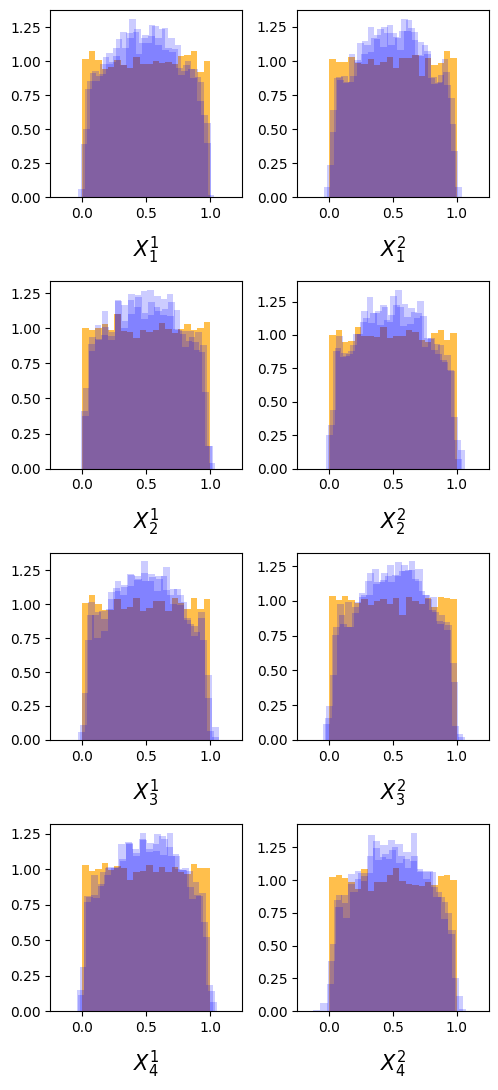

In [ ]:
visualize_marginals_multiple(test_loader.dataset.data, generations, fontsize=15, labelpad=15,
                                              alpha_data = .7, alpha_gen = .2, bins=20)

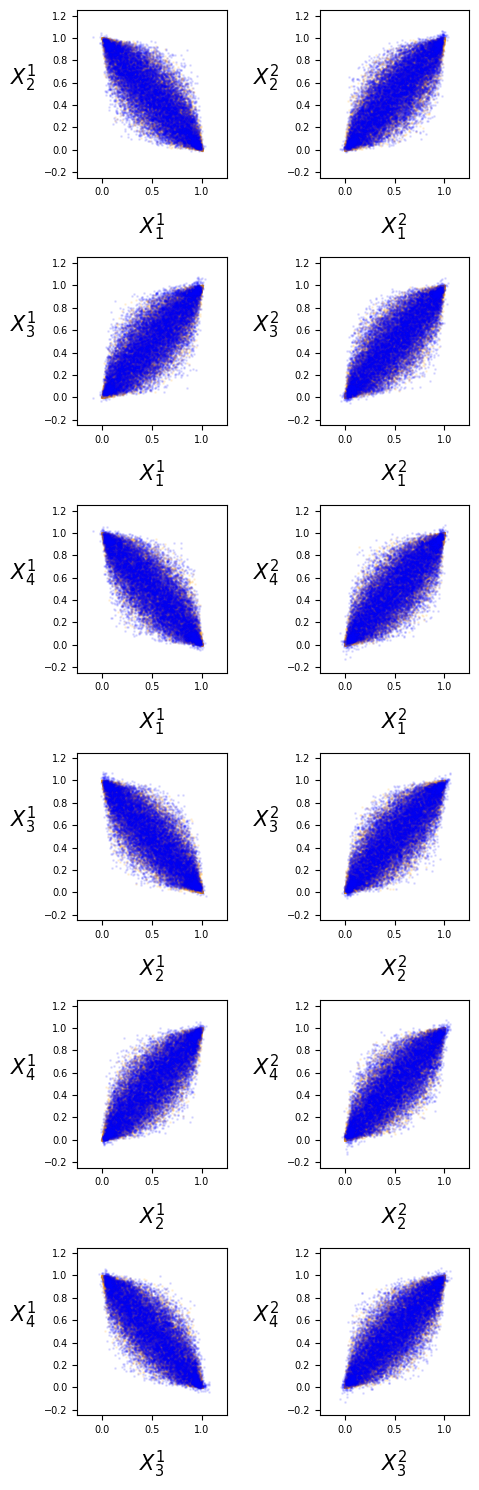

In [ ]:
visualize_joint_distributions_2d_multiple(test_loader.dataset.data, generations)#,alpha_data=.1, alpha_gen=.1)

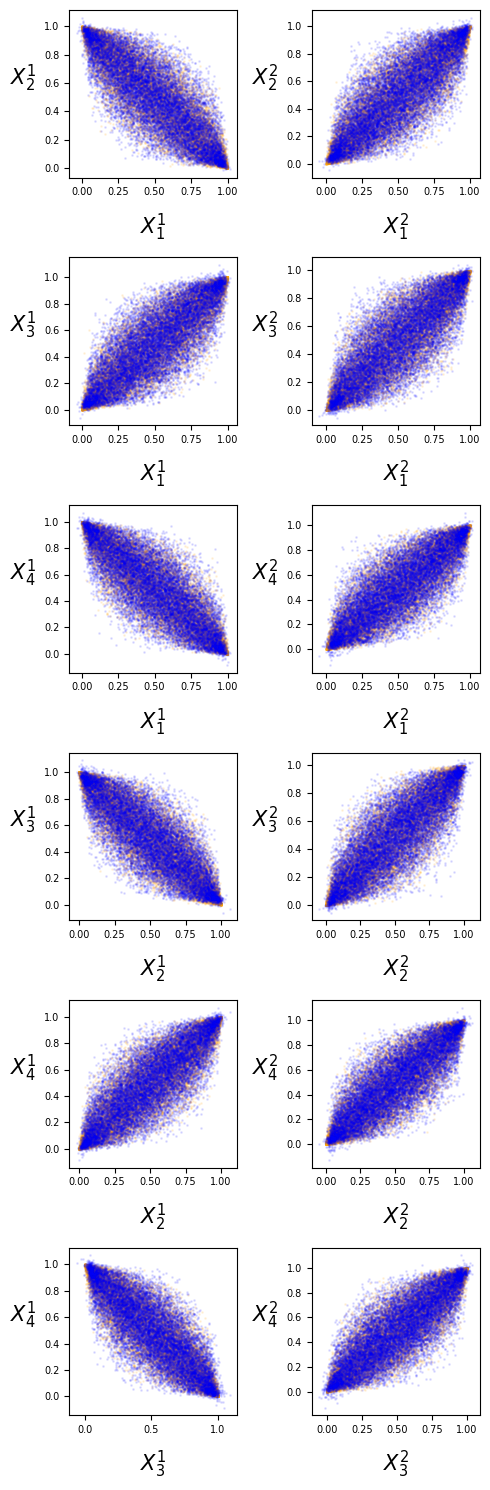

In [ ]:
visualize_joint_distributions_2d_multiple(test_loader.dataset.data, generations,alpha_data=.1, alpha_gen=.1)

## Covariances and correlation matrices

In [ ]:
data = [d.to(device) for d in next(iter(test_loader))]
gmrf_vae(*data)

In [ ]:
plot_cov_corr_matrices(gmrf_vae)

# Draft

In [ ]:
import json
import plotly.express as px
import plotly.graph_objects as go

In [ ]:
path = '/content/drive/MyDrive/Phd/mmvaes/unconditional_mean_std_metrics.json'
with open(path, 'r') as f:
  mean_std_metrics = json.load(f)

In [ ]:
def plot_method(method):
    model_colors = {}  # Dictionary to store colors for each model
    colors = px.colors.qualitative.Plotly  # Using a qualitative palette for distinct colors

    i = -1
    for model, metrics in mean_std_metrics.items():
        i += 1
        if i >= len(colors):  # Check if there are more models than colors
            i = 0  # Restart color index if needed
        model_colors[model] = colors[i]

    fig = go.Figure()

    for model, metrics in mean_std_metrics.items():
        if model.split('_')[1] == method:
            fig.add_trace(go.Scatter(
                x=[metrics['wsm']['mean']],
                y=[metrics['jsm']['mean']],
                mode='markers',
                marker=dict(color=model_colors[model]),
                name=model,
                text=f"Model: {model}<br>WSM Mean: {metrics['wsm']['mean']}<br>JSM Mean: {metrics['jsm']['mean']}"
            ))

    fig.update_layout(
        title='Unconditional '+method,
        xaxis_title='wsm',
        yaxis_title='jsm',
        legend_title='Model'
    )

    fig.show()


In [ ]:
for method in ['moe', 'poe', 'joint']:
    plot_method(method)